# Glaucoma Classification: A Classical Machine Learning Approach

### 👁️ Project Overview
This project aims to classify fundus images as **Glaucoma** or **Normal** using classical Machine Learning algorithms. 

Unlike Deep Learning approaches that learn features automatically, we will leverage **feature engineering** to manually extract meaningful patterns from the images. By transforming raw pixels into texture and color descriptors, we can effectively train classical models like **SVM**, **Random Forest**, and **XGBoost**.

### 🛠️ The Pipeline
1. **Preprocessing:** Resizing and noise reduction.
2. **Feature Extraction:** - **Texture:** LBP (Local Binary Patterns), GLCM (Gray-Level Co-occurrence Matrix), Gabor Filters.
   - **Structure:** HOG (Histogram of Oriented Gradients).
   - **Color:** Moments from HSV and LAB color spaces.
3. **Classification:** Training and evaluating the "Big 5" classical classifiers.

In [1]:
import cuml.accel
cuml.accel.install()

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


cuML: Accelerator installed.


In [2]:
import os
import multiprocessing

cores = str(multiprocessing.cpu_count())

os.environ["OMP_NUM_THREADS"] = cores
os.environ["MKL_NUM_THREADS"] = cores
os.environ["OPENBLAS_NUM_THREADS"] = cores
os.environ["VECLIB_MAXIMUM_THREADS"] = cores
os.environ["NUMEXPR_NUM_THREADS"] = cores

In [3]:
import pickle
from collections import defaultdict
from pathlib import Path

import cuml
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.linear_model import LogisticRegression as cuLogReg
from cuml.neighbors import KNeighborsClassifier as cuKNN
from cuml.svm import SVC as cuSVC
from scipy import ndimage as ndi
from scipy.stats import kurtosis, skew
from skimage.color import rgb2gray, rgb2hsv, rgb2lab
from skimage.feature import graycomatrix, graycoprops, hog, local_binary_pattern
from skimage.filters import gabor_kernel
from skimage.morphology import disk
from sklearn import set_config
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y
from tqdm.notebook import tqdm


In [4]:
# Configure Scikit-Learn to display pipelines as interactive diagrams
set_config(display="diagram")

# Enable tqdm progress bars for Pandas operations (e.g., df.progress_apply)
tqdm.pandas()

# Set the visual theme for Seaborn plots
sns.set_theme(style="whitegrid")

In [5]:
DATASET_PATH = Path("/kaggle/input/fundus-pytorch/train")
OUTPUT_PATH = Path("/kaggle/working")

## 🧰 Utility Functions

To keep the analysis clean and modular, we define several helper functions here. These handle:
1.  **Data Loading:** Efficiently reading images into a Pandas DataFrame.
2.  **Visualization:** Custom plotting for image grids and parallel feature comparison.
3.  **Preprocessing:** A standardized pipeline for **Imputation $\rightarrow$ Scaling $\rightarrow$ PCA**.
4.  **Evaluation:** Generating consistent classification reports and confusion matrices.

In [6]:
def dataset_loader(location: Path | str, cache=False):
    """
    Loads image paths and labels into a DataFrame.
    Optionally caches the result to pickle to speed up subsequent runs.
    """
    CACHE_PATH = OUTPUT_PATH / "original_data.pkl"
    if cache and CACHE_PATH.exists():
        print("Loading cached dataset")
        df = pd.read_pickle(CACHE_PATH)

    else:
        # Walk through the directory structure
        # Expected structure: root/class_name/image_file
        dataset = [
            (f"{dirname}/{filename}", dirname.split("/")[-1])
            for dirname, _, filenames in os.walk(location)
            for filename in filenames
        ]
        print(f"Found {len(dataset)} images.")

        paths, classes = zip(*dataset)

        df = pd.DataFrame(
            data={
                "has_glaucoma": classes,
                "paths": paths,
            }
        )

        # Read images using OpenCV (BGR format by default)
        df["images"] = df["paths"].progress_apply(cv2.imread)
        df["has_glaucoma"] = df["has_glaucoma"].progress_apply(int)

        if cache:
            df.to_pickle(CACHE_PATH)

    return df

In [7]:
def plot_parallel_columns(df, col_names, num_samples=3, random_state=42):
    """
    Visualizes multiple columns (features/images) for the same sample side-by-side.
    Useful for comparing Original Image vs. HOG vs. LBP etc.
    """
    # 1. Sample the dataframe
    samples = df.sample(num_samples, random_state=random_state)
    num_cols = len(col_names)

    # 2. Create the figure
    fig, axes = plt.subplots(
        num_samples, num_cols, figsize=(3 * num_cols, 3 * num_samples)
    )

    # Ensure axes is a 2D array even for 1 sample or 1 column
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)
    if num_cols == 1:
        axes = np.expand_dims(axes, axis=-1)

    for row_idx, (df_idx, row) in enumerate(samples.iterrows()):
        for col_idx, col_name in enumerate(col_names):
            ax = axes[row_idx, col_idx]

            # Extract the numpy array from the specific row/column
            display_img = row[col_name]

            # --- Visualization Logic ---
            if display_img is None:
                ax.text(0.5, 0.5, "Empty", ha="center", va="center")
            elif len(display_img.shape) == 3:
                # Standard BGR to RGB for OpenCV images
                show_img = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
                ax.imshow(show_img)
            else:
                # Handle 1D flattened arrays or 2D grayscale
                if len(display_img.shape) == 1:
                    side = int(np.sqrt(len(display_img)))
                    display_img = display_img.reshape(side, side)
                ax.imshow(display_img, cmap="gray")

            # --- Formatting ---
            # Title for the top row only
            if row_idx == 0:
                ax.set_title(col_name.upper(), fontsize=10, fontweight="bold", pad=10)

            # Row Labels on the far left column
            if col_idx == 0:
                filename = row.get("paths", "N/A").split("/")[-1]
                glaucoma_status = row.get("has_glaucoma", "N/A")
                ax.set_ylabel(
                    f"Index: {df_idx}\nGlaucoma: {glaucoma_status}\n{filename}",
                    rotation=90,
                    fontsize=8,
                    fontweight="bold",
                    labelpad=5,
                )

            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color("#cccccc")

    plt.tight_layout()
    plt.show()


In [14]:
def _plot_steps(steps_list):
    """
    Helper to plot a sequence of processing steps (e.g., Original -> Gray -> Filtered).
    """
    num_steps = len(steps_list)
    fig, axes = plt.subplots(1, num_steps, figsize=(3 * num_steps, 4))

    # Handle case where there is only 1 step (axes is not a list)
    if num_steps == 1:
        axes = [axes]

    for idx, (title, image) in enumerate(steps_list):
        ax = axes[idx]

        # --- Visualization Logic ---
        display_img = image.copy()

        # Check if color (3 channels) or grayscale (2 channels)
        if len(display_img.shape) == 3:
            # Standard BGR to RGB for OpenCV images
            display_img = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
            ax.imshow(display_img)
        else:
            # Grayscale
            ax.imshow(display_img, cmap="gray")

        # --- Formatting ---
        ax.set_title(title.upper(), fontsize=10, fontweight="bold", pad=10)
        ax.set_xticks([])
        ax.set_yticks([])

        # Add the subtle frame (from your original code)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color("#cccccc")

    plt.tight_layout()
    plt.show()


In [30]:
def fit_feature_pipeline(X_train, n_components=100):
    """
    Creates and fits a processing pipeline: Imputer -> Scaler -> PCA.
    
    Why this specific order?
    1. Imputer: Hand-crafted features (like skewness) can produce NaNs (e.g., division by zero).
    2. Scaler: PCA is sensitive to scale; large magnitude features would dominate variance.
    3. PCA: Reduces dimensionality to capture 95% variance, speeding up training.
    """
    # Define the pipeline steps
    pipeline = Pipeline(
        [
            # 1. Imputer: Replace NaNs/Infs with the median of the column
            #    (Crucial for manual feature engineering where div/0 occurs)
            ("imputer", SimpleImputer(strategy="median")),
            # 2. Scaler: Standardize features by removing the mean and scaling to unit variance
            ("scaler", StandardScaler()),
            # 3. PCA: Linear dimensionality reduction
            ("pca", PCA(n_components=n_components)),
        ]
    )

    # Fit the pipeline to X_train and transform it in one step
    X_train_pca = pipeline.fit_transform(X_train)

    print(f"Original Feature Count: {X_train.shape[1]}")
    print(f"Reduced Feature Count: {X_train_pca.shape[1]}")

    return X_train_pca, pipeline

In [41]:
def data_split(df, x_column, y_column="has_glaucoma", cache=False, n_components=100):
    """
    Splits data into Train (60%), Validation (20%), and Test (20%).
    Applies the PCA pipeline to all sets based *only* on Training statistics to avoid leakage.
    """
    CACHE_PATH = OUTPUT_PATH / f"data_split_{x_column}.pkl"
    if cache and CACHE_PATH.exists():
        print("Loading cached data splits")
        with open(CACHE_PATH, "rb") as f:
            X_train_pca, X_val_pca, X_test_pca, y_train, y_val, y_test = pickle.load(f)

    else:
        X = np.stack(df[x_column].values)
        y = df[y_column].values

        print(f"Shape of X (Features): {X.shape}")
        print(f"Shape of y (Labels): {y.shape}")

        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=0.20, random_state=42, stratify=y
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val,
            y_train_val,
            test_size=0.25,
            random_state=42,
            stratify=y_train_val,
        )

        print("Fitting feature pipeline")
        X_train_pca, pipeline = fit_feature_pipeline(X_train, n_components=n_components)
        print("Transforming validation features")
        X_val_pca = pipeline.transform(X_val)
        print("Transforming test features")
        X_test_pca = pipeline.transform(X_test)

        if cache:
            with open(CACHE_PATH, "wb") as f:
                pickle.dump(
                    (X_train_pca, X_val_pca, X_test_pca, y_train, y_val, y_test), f
                )

    print(f"Shape of X_train (Train Features): {X_train_pca.shape}")
    print(f"Shape of X_val (Validation Features): {X_val_pca.shape}")
    print(f"Shape of X_test (Test Features): {X_test_pca.shape}")
    print(f"Shape of y_train (Train Labels): {y_train.shape}")
    print(f"Shape of y_val (Validation Labels): {y_val.shape}")
    print(f"Shape of y_test (Test Labels): {y_test.shape}")

    return X_train_pca, X_val_pca, X_test_pca, y_train, y_val, y_test

In [16]:
def evaluate_predictions(y_test, y_pred, title=""):
    """
    Plots a confusion matrix and classification report heatmap.
    """
    print("Classification Report | " + title)
    print(
        classification_report(y_test, y_pred, target_names=["No Glaucoma", "Glaucoma"])
    )

    report_dict = classification_report(
        y_test, y_pred, target_names=["No Glaucoma", "Glaucoma"], output_dict=True
    )
    report_df = pd.DataFrame(report_dict).iloc[:-1, :2].T

    cm = confusion_matrix(y_test, y_pred)
    cm_pct = confusion_matrix(y_test, y_pred, normalize="true")

    labels = [f"{v1}\n({v2:.2%})" for v1, v2 in zip(cm.flatten(), cm_pct.flatten())]
    labels = np.asarray(labels).reshape(cm.shape)

    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    if title:
        fig.suptitle(title)

    sns.heatmap(
        report_df,
        annot=True,
        cmap="RdYlGn",
        cbar=True,
        fmt=".2%",  # vmin=0, vmax=1,
        ax=ax[0],
    )

    ax[0].set_title("Metrics per Class")
    ax[0].set_xlabel("Metric")
    ax[0].set_ylabel("Class")
    ax[0].tick_params(axis="both", which="major")

    sns.heatmap(
        cm,
        annot=labels,
        fmt="",
        cmap="Blues",
        cbar=True,
        ax=ax[1],
        xticklabels=["No Glaucoma", "Glaucoma"],
        yticklabels=["No Glaucoma", "Glaucoma"],
    )
    ax[1].set_title("Confusion Matrix Analysis")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

    return report_dict

In [17]:
def train_evaluate_model(model, X_train, X_test, y_train, y_test, title):
    """
    Wrapper to fit a model and immediately display results.
    """
    print("Training model | " + title)
    model.fit(X_train, y_train)

    print("Computing predictions | " + title)
    y_pred = model.predict(X_test)

    report_dict = evaluate_predictions(y_test, y_pred, title=title)

    return model, y_pred, report_dict

## 1. Data Loading & Inspection

We begin by loading the dataset into memory. Our `dataset_loader` function handles the traversal of directory structures and reads the image files using OpenCV. 

**Note:** We immediately check `df.info()` to ensure:
1.  All images were loaded correctly (no null values).
2.  The `has_glaucoma` column is correctly typed as an integer (0 or 1).
3.  The memory usage is within acceptable limits.

In [18]:
df = dataset_loader(DATASET_PATH)
df.info()

Found 8621 images.


  0%|          | 0/8621 [00:00<?, ?it/s]

  0%|          | 0/8621 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   has_glaucoma  8621 non-null   int64 
 1   paths         8621 non-null   object
 2   images        8621 non-null   object
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


## 2. Exploratory Data Analysis (EDA)

Before extracting features, we must understand the nature of our data. We focus on three key aspects:
1.  **Input Dimensions:** How large are the images? (Determines computational cost).
2.  **Class Balance:** Is the dataset skewed? (Determines if we need specific metrics like F1-Score).
3.  **Visual Inspection:** What do the inputs actually look like?

In [19]:
# Check the dimensions of the first image
# Note: Large images (e.g., 2000x2000) produce millions of pixels. 
# For classical ML, we often need to resize or use strong feature extractors to manage this dimensionality.
sample_shape = df["images"][0].shape
print(f"Original Image Shape: {sample_shape}")

Original Image Shape: (512, 512, 3)


### Class Balance Analysis
In medical diagnosis, datasets are often imbalanced (more healthy patients than sick ones). We need to verify this distribution to choose the right evaluation metrics.

Class Distribution:
has_glaucoma
0    5293
1    3328
Name: count, dtype: int64


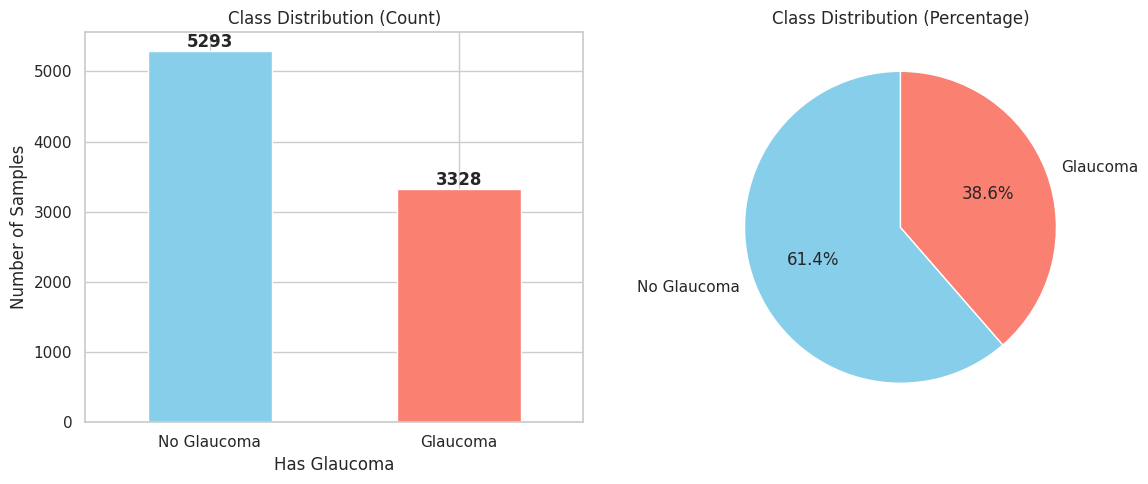

In [20]:
print("Class Distribution:")
value_counts = df["has_glaucoma"].value_counts()
print(value_counts)

value_counts.index = ["No Glaucoma", "Glaucoma"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

value_counts.plot(kind="bar", ax=axes[0], color=["skyblue", "salmon"])
axes[0].set_title("Class Distribution (Count)")
axes[0].set_xlabel("Has Glaucoma")
axes[0].set_ylabel("Number of Samples")
axes[0].tick_params(axis="x", rotation=0)

# Add the numerical labels on top of the bars
for i, v in enumerate(value_counts):
    axes[0].text(i, v + 50, str(v), ha="center", fontweight="bold")

value_counts.plot(
    kind="pie",
    ax=axes[1],
    autopct="%1.1f%%",
    startangle=90,
    colors=["skyblue", "salmon"],
)
axes[1].set_title("Class Distribution (Percentage)")
axes[1].set_ylabel("")

# Adjust layout so titles don't overlap
plt.tight_layout()
plt.show()

### Visual Sample
Let's look at a few random samples from the dataset to verify that the images are loaded correctly and to observe the visual differences (if any) between the classes.

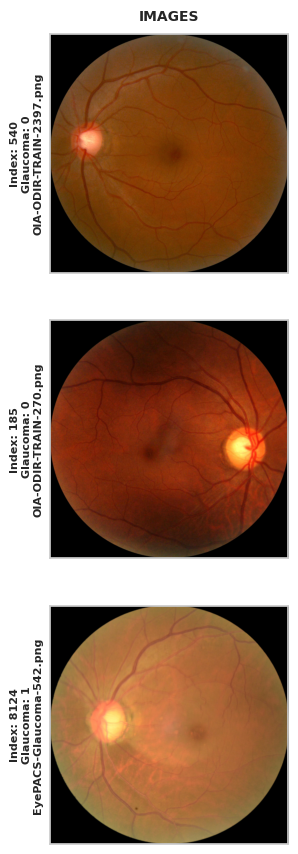

In [21]:
plot_parallel_columns(df, ["images"], num_samples=3)

## 3. Model Definition & Experimental Setup

To rigorously evaluate our features, we define a standardized **"Model Factory."** For every feature set we generate (Raw Pixels, HOG, LBP, etc.), we will run the same battery of 5 classifiers. To ensure fair comparison, we use:
1.  **Stratified K-Fold Cross Validation:** Preserves the percentage of Glaucoma samples in every fold (critical for our imbalanced data).
2.  **Hyperparameter Tuning:** We use `GridSearchCV` to find the best settings for each model automatically.
3.  **F1-Score Optimization:** In medical diagnostics, Accuracy can be misleading. We prioritize F1-Score to balance Precision and Recall.

### Special Note: Custom Logistic Regression
As a project requirement, we utilize a **custom implementation** of Logistic Regression built from scratch using NumPy. It implements Gradient Descent with L1/L2 regularization and is fully compatible with Scikit-Learn's pipeline.

In [22]:
# Initialize a dictionary to store the performance metrics of different experiments
# Structure: results['Feature_Type'] = [ (Model_Name, Accuracy, F1, ...) ]
results = defaultdict(list)

In [23]:
class LogisticRegressionScratch(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, max_iter=1000, penalty="l2", C=1.0):
        # Param names must match GridSearchCV keys exactly
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.penalty = penalty
        self.C = C

    def _sigmoid(self, z):
        # Apply sigmoid function: 1 / (1 + e^-z)
        # We clip z to [-500, 500] to prevent numerical overflow/underflow in np.exp()
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        num_samples, num_features = X.shape

        self.coef_ = np.zeros(num_features)
        self.intercept_ = 0.0

        for _ in range(self.max_iter):
            linear_model = np.dot(X, self.coef_) + self.intercept_
            y_predicted = self._sigmoid(linear_model)

            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / num_samples) * np.sum(y_predicted - y)

            if self.penalty == "l2":
                dw += (1 / self.C) * self.coef_ / num_samples
            elif self.penalty == "l1":
                dw += (1 / self.C) * np.sign(self.coef_) / num_samples

            self.coef_ -= self.learning_rate * dw
            self.intercept_ -= self.learning_rate * db

        return self

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        prob_positive = self._sigmoid(np.dot(X, self.coef_) + self.intercept_)
        return np.column_stack([1 - prob_positive, prob_positive])

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

In [35]:
def models_factory():
    """
    Returns a list of (GridSearchCV, ModelName) tuples optimized for NVIDIA T4 GPU.
    Replaces standard sklearn with cuML for massive speedups.
    """
    # StratifiedKFold for balanced validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    models = [
        (
            GridSearchCV(
                # cuML version of Logistic Regression
                estimator=cuLogReg(max_iter=4000),
                param_grid={
                    "C": [0.01, 0.1, 1, 10, 100],
                    # Note: cuML currently optimized for 'l2' or None
                    "penalty": ["l2"], 
                },
                cv=cv,
                scoring="f1",
                n_jobs=None, # GPU handles its own parallelism
                verbose=2,
            ),
            "Logistic Regression (GPU)",
        ),
        (
            GridSearchCV(
                # cuML version of SVC - significantly faster on T4
                estimator=cuSVC(random_state=42),
                param_grid={
                    "kernel": ["linear"],
                    "C": [0.1, 1, 10],
                    "class_weight": [None, "balanced"],
                },
                cv=cv,
                scoring="f1",
                n_jobs=None,
                verbose=2,
            ),
            "SVC (GPU)",
        ),
        (
            GridSearchCV(
                # cuML version of KNN
                estimator=cuKNN(),
                param_grid={
                    "n_neighbors": [5, 25, 51],
                    "weights": ["uniform"], # cuML KNN defaults to uniform/fastest
                    "metric": ["euclidean", "manhattan"],
                },
                cv=cv,
                scoring="f1",
                n_jobs=None,
                verbose=2,
            ),
            "KNN (GPU)",
        ),
        (
            GridSearchCV(
                # cuML version of Random Forest
                estimator=cuRF(random_state=42),
                param_grid={
                    "n_estimators": [300],
                    "max_depth": [10, 15],
                    # 'max_features' in cuRF is defined by a float (0.0 to 1.0) 
                    # or 'auto' (sqrt). 'sqrt' is the default.
                },
                cv=cv,
                scoring="f1",
                n_jobs=None,
                verbose=2,
            ),
            "Random Forest (GPU)",
        ),
        (
            GridSearchCV(
                # XGBoost using native CUDA support
                estimator=xgb.XGBClassifier(
                    objective="binary:logistic", 
                    random_state=42, 
                    tree_method='hist', # Best for T4
                    device='cuda'       # Explicitly use the GPU
                ),
                param_grid={
                    "n_estimators": [300],
                    "max_depth": [3, 5, 7],
                    "learning_rate": [0.1],
                    "scale_pos_weight": [1, 3],
                    "subsample": [0.8],
                    "colsample_bytree": [0.7],
                },
                cv=cv,
                scoring="f1",
                n_jobs=None,
                verbose=2,
            ),
            "XGBoost (GPU)",
        ),
    ]
    return models

## 4. Experiment 1: The Baseline (Raw Pixels)

Before diving into complex feature extraction, we must establish a baseline performance. The simplest approach in computer vision is the **"Bag of Pixels"** method:
1.  Resize the image to a small fixed size (64x64).
2.  Convert to Grayscale (color is often secondary for structure).
3.  Flatten the 2D matrix into a 1D vector.

**Hypothesis:** If our advanced features (HOG, LBP) cannot beat this simple baseline, they are not worth the computational cost.

In [25]:
def simple_features(img_rgb):
    """
    Baseline feature extractor.
    Resizes image to 64x64 and flattens it.
    Result: A vector of 4096 raw pixel intensities.
    """
    img_resized = cv2.resize(img_rgb, (64, 64))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_flattened = img_gray.flatten()
    return img_flattened

In [26]:
# Apply the function to the dataset
df["simple_features"] = df["images"].progress_apply(simple_features)
df.info()

  0%|          | 0/8621 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   has_glaucoma     8621 non-null   int64 
 1   paths            8621 non-null   object
 2   images           8621 non-null   object
 3   simple_features  8621 non-null   object
dtypes: int64(1), object(3)
memory usage: 269.5+ KB


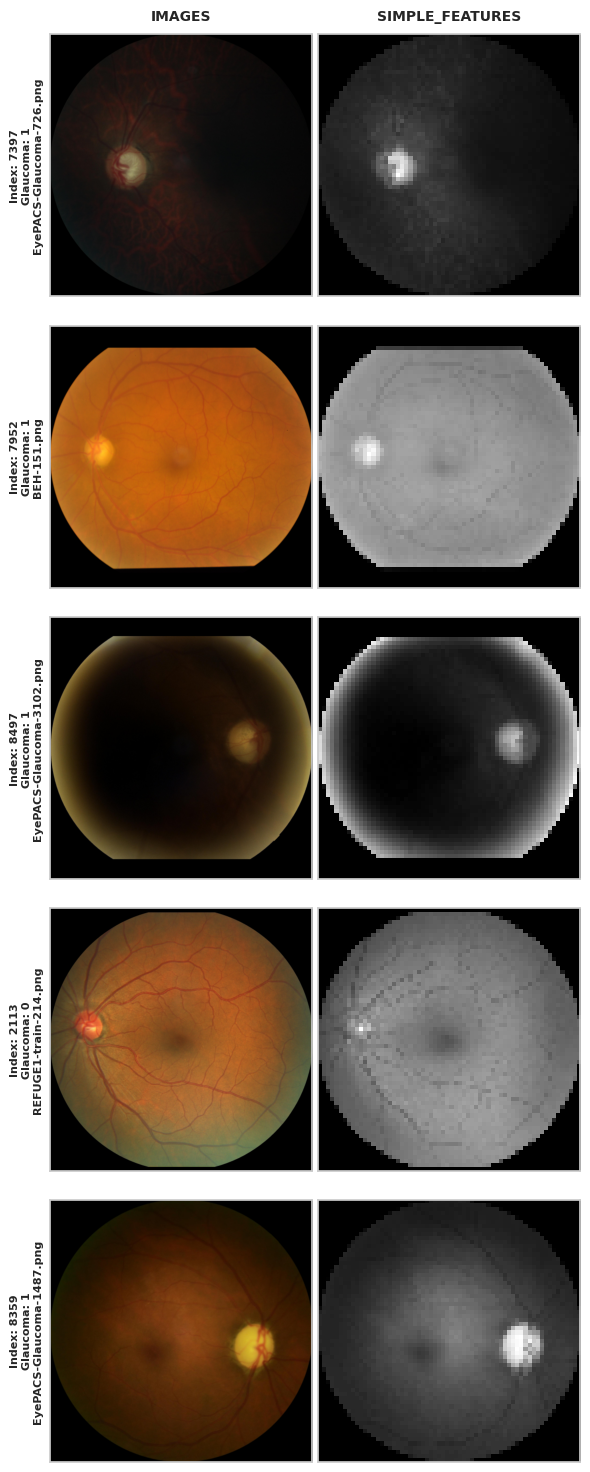

In [27]:
# Visualize the degradation
# Left: Original High-Res Image. Right: The 64x64 input the model sees.
plot_parallel_columns(df, ["images", "simple_features"], num_samples=5, random_state=9)

In [33]:
# Split data and apply PCA pipeline.
# Note: PCA is critical here because adjacent pixels are highly correlated.
X_train, X_val, X_test, y_train, y_val, y_test = data_split(
    df, x_column="simple_features", y_column="has_glaucoma", n_components=100
)

Shape of X (Features): (8621, 4096)
Shape of y (Labels): (8621,)
Fitting feature pipeline
Original Feature Count: 4096
Reduced Feature Count: 100
Transforming validation features
Transforming test features
Shape of X_train (Train Features): (5172, 100)
Shape of X_val (Validation Features): (1724, 100)
Shape of X_test (Test Features): (1725, 100)
Shape of y_train (Train Labels): (5172,)
Shape of y_val (Validation Labels): (1724,)
Shape of y_test (Test Labels): (1725,)


Training on Feature Matrix Shape: (5172, 100)
Training model | Logistic Regression (GPU) - Simple Approach
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   1.5s
[CV] END .................................C=0.01, penalty=l2; total time=   0.2s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.2s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.2s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.2s
[CV] END ....................................C=1, penalty=l2; total time=   0.3s
[CV] END ....................................C=1, penalty=l2; total time=   0.2s
[CV] END ....................................C=1, penalty=l2; total time=   0.2s
[CV] END ...................................C=10, penalty=l2; total time=   0.7s
[CV] END ..............

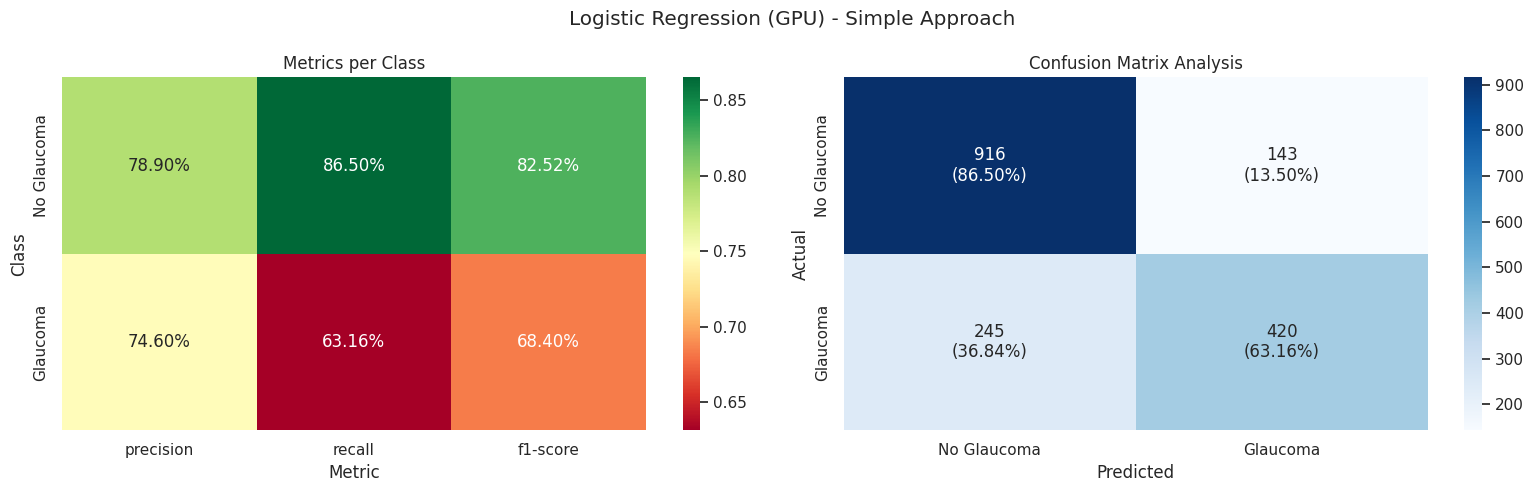

Training model | SVC (GPU) - Simple Approach
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   1.1s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.2s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.2s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   1.8s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.2s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.2s
[CV] END ..............C=1, class_weight=None, kernel=linear; total time=   0.2s
[CV] END ..............C=1, class_weight=None, kernel=linear; total time=   0.2s
[CV] END ..............C=1, class_weight=None, kernel=linear; total time=   0.2s
[CV] END ..........C=1, class_weight=balanced, kernel=linear; total time=   0.2s
[CV] END ..........C=1, class_weight=balanced, kernel=linear; total time=   0.2s
[CV]

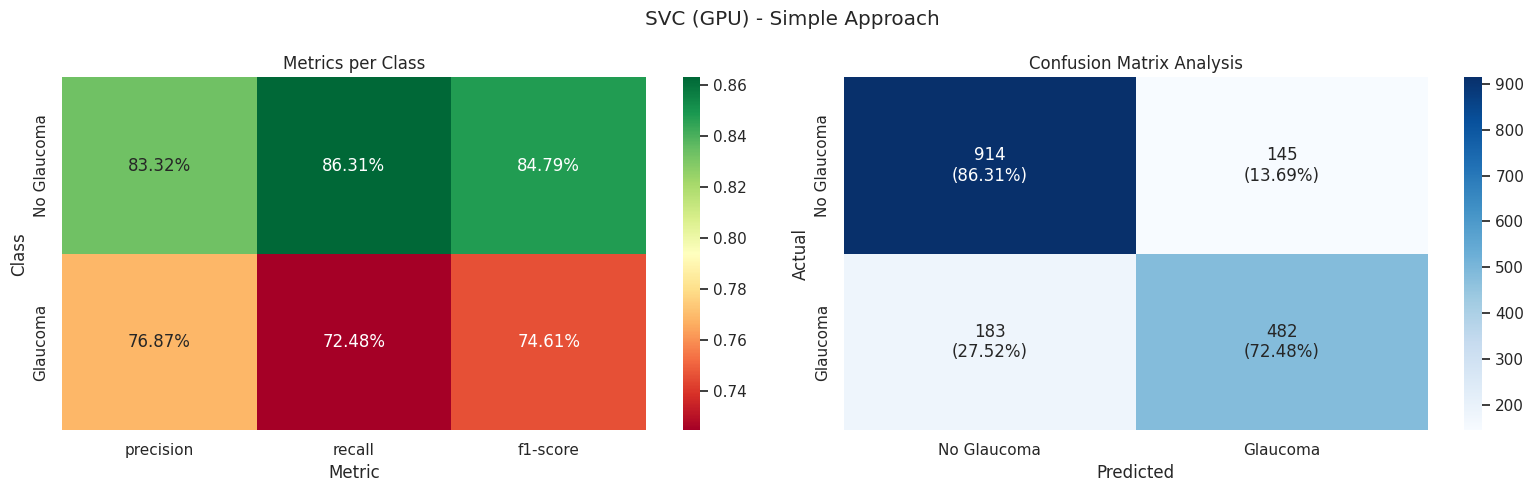

Training model | KNN (GPU) - Simple Approach
Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.9s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ..metric=euclidean, n_neighbors=25, weights=uniform; total time=   0.0s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ..metric=euclidean, n_neighbors=25, weights=uniform; total time=   0.0s
Unused keyword parameter: n_jobs during cuML estimator initialization


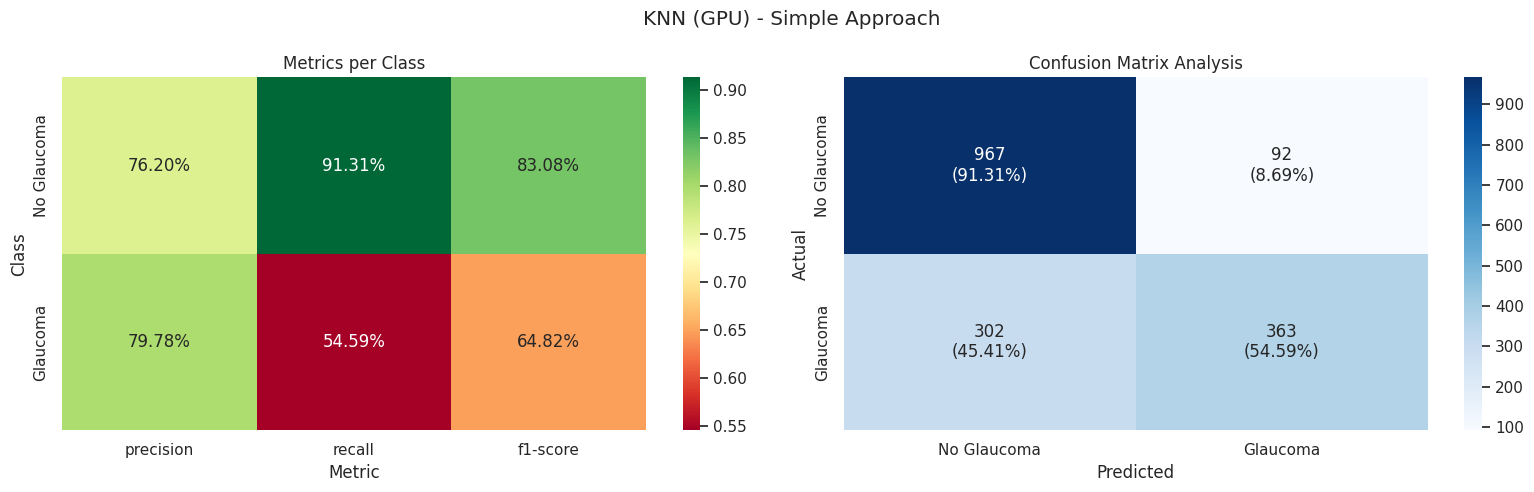

Training model | Random Forest (GPU) - Simple Approach
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .....................max_depth=10, n_estimators=300; total time=   1.4s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.5s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.5s
[CV] END .....................max_depth=15, n_estimators=300; total time=   0.7s
[CV] END .....................max_depth=15, n_estimators=300; total time=   0.7s
[CV] END .....................max_depth=15, n_estimators=300; total time=   0.7s
Computing predictions | Random Forest (GPU) - Simple Approach
Classification Report | Random Forest (GPU) - Simple Approach
              precision    recall  f1-score   support

 No Glaucoma       0.78      0.95      0.86      1059
    Glaucoma       0.89      0.58      0.70       665

    accuracy                           0.81      1724
   macro avg       0.83      0.77      0.78      1724
weig

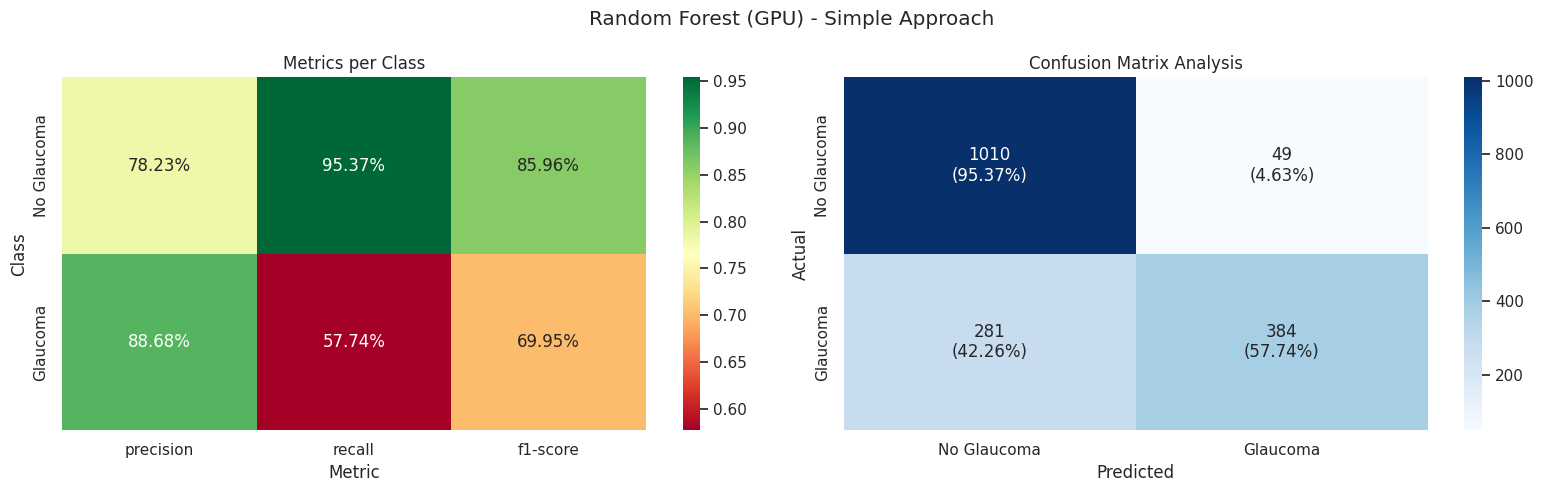

Training model | XGBoost (GPU) - Simple Approach
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [12:54:46] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=3, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=3, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=3, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_d

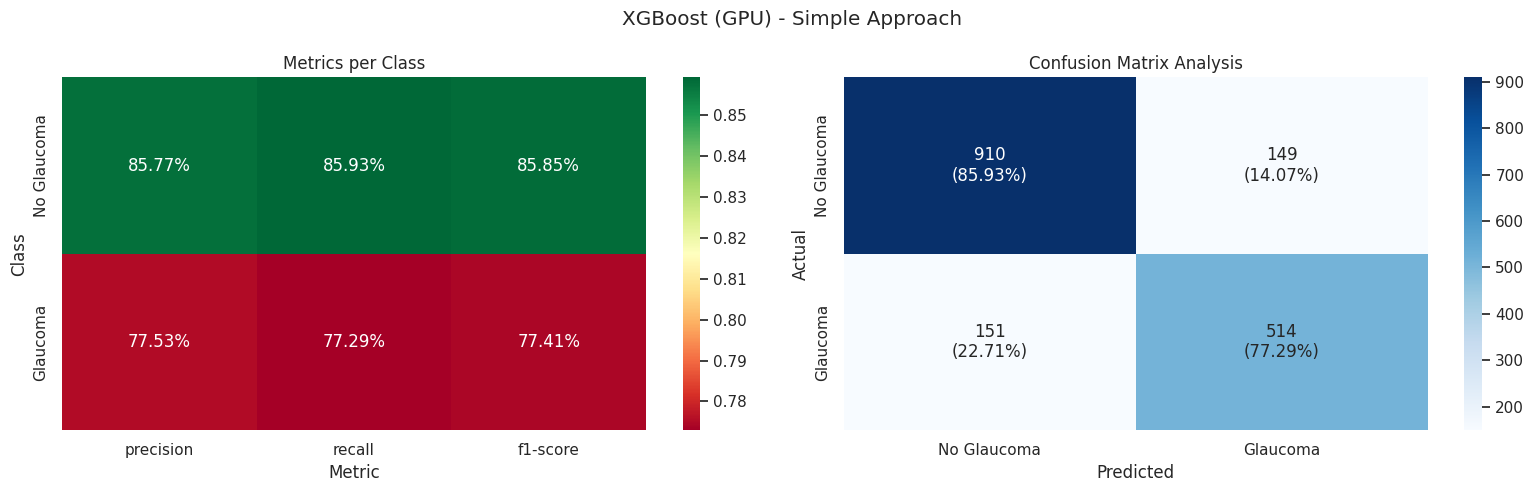

In [36]:
# Load the fresh model instances
models = models_factory()
print(f"Training on Feature Matrix Shape: {X_train.shape}")

# Iterate through every model type defined in the factory
for model, title in models:
    # Train, Predict, and Plot results
    model, y_pred, report_dict = train_evaluate_model(
        model, X_train, X_val, y_train, y_val, title=title + " - Simple Approach"
    )
    # Store results for final comparison
    results["simple_features"].append((title, model, y_pred, report_dict))

## 5. Experiment 2: Advanced Feature Engineering

The "Bag of Pixels" approach (Experiment 1) ignores the spatial structure of the eye. In this experiment, we apply domain-specific preprocessing and extract "hand-crafted" features widely used in medical imaging.

### Phase 1: Preprocessing Pipeline (The Graham Method)
Raw fundus images often suffer from uneven lighting (vignetting). We apply a standard technique popularized by Ben Graham (Kaggle methodology):
1.  **Green Channel:** In fundus photography, the green channel holds the most contrast for the optic disc and vessels.
2.  **Illumination Correction:** We subtract a blurred version of the image from itself. This acts as a **High-Pass Filter**, removing slow lighting changes while keeping sharp details (vessels).
3.  **CLAHE:** Adaptive histogram equalization to maximize local contrast.

In [38]:
def preprocess_image(img, visualize=False):
    """
    Applies the "Graham Method" to enhance fundus images.
    Steps: Resize -> Green Channel -> Gaussian Blur Subtraction -> CLAHE.
    """
    steps = []

    # 0. Original
    if visualize:
        steps.append(("Original", img))

    # Resize
    img_resized = cv2.resize(img, (128, 128))
    if visualize:
        steps.append(("Resized", img_resized))

    # 1. Channel Selection (Green)
    img_gray = img_resized[:, :, 1]
    if visualize:
        steps.append(("Green Ch.", img_gray))

    # 2. Illumination Correction (The Graham Method)
    # We use GaussianBlur to estimate the local background (illumination)
    # SigmaX=10 is approx 1/10th of the image size, good for 128px images
    img_blurred = cv2.GaussianBlur(img_gray, (0, 0), 10)
    if visualize:
        steps.append(("Background Est.", img_blurred))

    # Formula: 4 * Original - 4 * Background + 128
    # This acts like a high-pass filter: removing slow gradients (lighting)
    # and keeping high-frequency details (vessels).
    img_corrected = cv2.addWeighted(img_gray, 4, img_blurred, -4, 128)
    if visualize:
        steps.append(("Illum. Corrected", img_corrected))

    # 3. Contrast Enhancement (CLAHE)
    # Now that lighting is flat gray, CLAHE works much better
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_equalized = clahe.apply(img_corrected)

    # Final Result
    final_img = img_equalized.astype(np.uint8)
    if visualize:
        steps.append(("Final CLAHE", final_img))

    # Trigger Visualization
    if visualize:
        _plot_steps(steps)

    return final_img

### Phase 2: Feature Extraction Strategy
Instead of raw pixels, we describe the image using statistical descriptors. This allows the classifiers to learn "What does Glaucoma *look* like?" rather than "What is the pixel value at (10,10)?"

1.  **Intensity Stats:** Mean, Std Dev, and Skewness (Glaucomatous eyes often have different brightness profiles).
2.  **LBP (Local Binary Patterns):** Encodes micro-textures by comparing a pixel to its neighbors. Excellent for detecting surface roughness.
3.  **GLCM (Gray-Level Co-occurrence Matrix):** Calculates how often pairs of pixels with specific values appear next to each other. Measures "Homogeneity" and "Contrast."
4.  **HOG (Histogram of Oriented Gradients):** Captures edge directions and shapes (critical for the Optic Disc shape).

In [39]:
def image_feature_engineering(img, visualize=False):
    """
    Extracts a rich feature vector combining:
    1. Intensity Stats (3 features)
    2. LBP Histogram (Texture)
    3. GLCM Properties (Texture Consistency)
    4. HOG (Shape/Edges)
    """
    # --- 1. Intensity Features ---
    # Logic: Mean, Std, Skewness of the flattened image
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    skewness = skew(img.flatten())

    feat_intensity = np.array([mean_intensity, std_intensity, skewness])

    # --- 2. LBP Histogram Features ---
    # Logic: LBP (R=1, P=8, uniform) -> Histogram (bins inferred from data max)
    radius = 1
    n_points = 8 * radius
    method = "uniform"

    lbp_image = local_binary_pattern(img, n_points, radius, method)

    # From HistogramTransformer: bins=None implies int(x.max() + 1)
    n_bins = int(lbp_image.max() + 1)
    hist_range = (0, n_bins)

    feat_lbp_hist, _ = np.histogram(
        lbp_image.ravel(), bins=n_bins, range=hist_range, density=True
    )

    # --- 3. GLCM Properties ---
    # Logic: GLCM (dist=[1], angles=[0, 45, 90, 135]) -> Texture Properties
    distances = [1, 3, 5]
    angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
    levels = 256

    # Note: graycomatrix requires integer types.
    # If img is float (0-1), it might need scaling/casting, but we strictly follow the snippet logic provided.
    # Assuming img is already in suitable uint format (0-255) as per typical GLCM usage.
    glcm = graycomatrix(
        img,
        distances=distances,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True,
    )

    glcm_properties = [
        "contrast",
        "dissimilarity",
        "homogeneity",
        "energy",
        "correlation",
    ]
    feat_glcm = []

    for prop in glcm_properties:
        # Calculate property and flatten results for all angles
        val = graycoprops(glcm, prop).flatten()
        feat_glcm.extend(val)

    feat_glcm = np.array(feat_glcm)

    # --- 4. HOG Features ---
    # Logic: Skimage HOG with specific parameters from the instance (not class defaults)
    # Instance used: orientations=8, pixels_per_cell=(8, 8)
    orientations = 8
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    block_norm = "L2-Hys"

    # We call hog twice if visualization is needed, as the snippet's transform
    # strictly has visualize=False.
    if visualize:
        feat_hog, hog_image = hog(
            img,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm=block_norm,
            visualize=True,
            feature_vector=True,
            channel_axis=None,
        )

        # Visualization Block
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        ax = axes.ravel()

        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].set_title("Original Image")

        ax[1].imshow(lbp_image, cmap=plt.cm.gray)
        ax[1].set_title("LBP Image")

        ax[2].imshow(hog_image, cmap=plt.cm.gray)
        ax[2].set_title("HOG Visualization")

        for a in ax:
            a.axis("off")
        plt.tight_layout()
        plt.show()

    else:
        feat_hog = hog(
            img,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm=block_norm,
            visualize=False,
            feature_vector=True,
            channel_axis=None,
        )

    # --- Concatenate All Features ---
    full_feature_vector = np.concatenate(
        [feat_intensity, feat_lbp_hist, feat_glcm, feat_hog]
    )

    return full_feature_vector

In [40]:
print("Running Preprocessing Pipeline (Graham Method)...")
df["images_preprocessed"] = df["images"].progress_apply(preprocess_image)

Running Preprocessing Pipeline (Graham Method)...


  0%|          | 0/8621 [00:00<?, ?it/s]

In [42]:
print("Extracting Features (Intensity + LBP + GLCM + HOG)...")
df["engineered_features"] = df["images_preprocessed"].progress_apply(
    image_feature_engineering
)
df.info()

Extracting Features (Intensity + LBP + GLCM + HOG)...


  0%|          | 0/8621 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   has_glaucoma         8621 non-null   int64 
 1   paths                8621 non-null   object
 2   images               8621 non-null   object
 3   simple_features      8621 non-null   object
 4   images_preprocessed  8621 non-null   object
 5   engineered_features  8621 non-null   object
dtypes: int64(1), object(5)
memory usage: 404.2+ KB


### Visual Verification
Before training, we visually inspect the pipeline on a few random samples to ensure:
1.  **Preprocessing** effectively normalized the lighting.
2.  **Feature Maps** (LBP/HOG) are capturing meaningful structures (vessels/discs).

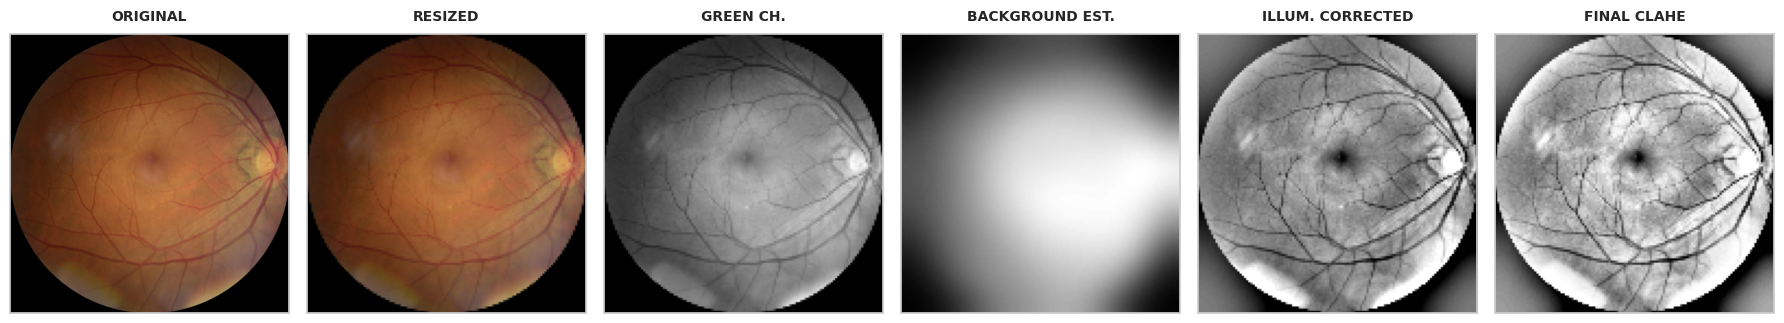

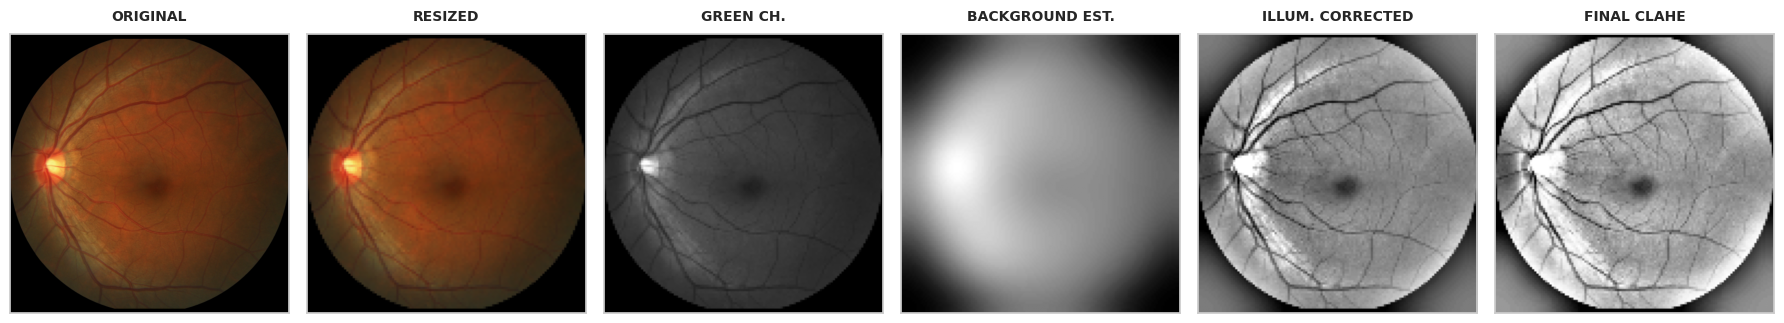

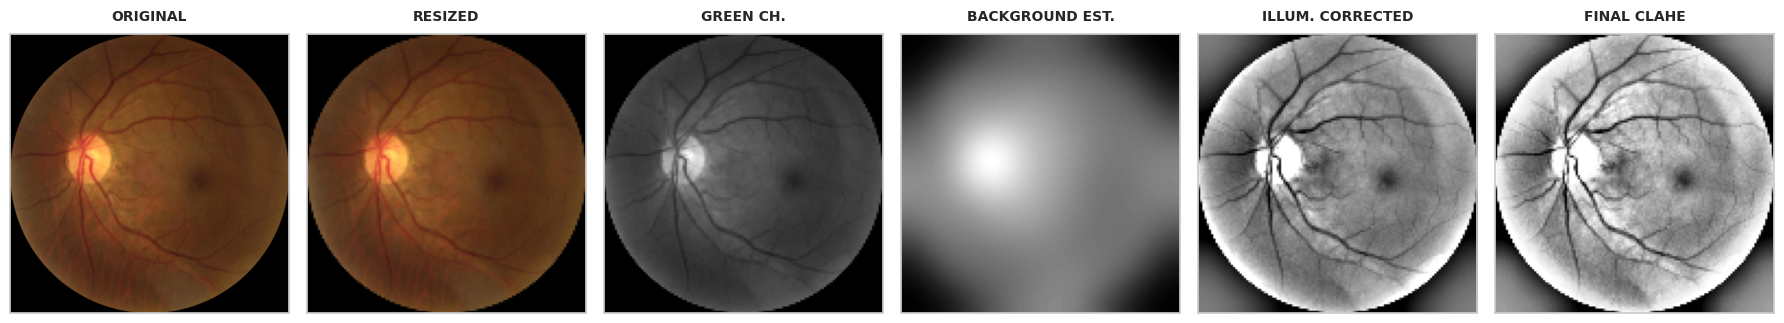

In [43]:
for i in range(3):
    preprocess_image(df["images"][i], visualize=True)

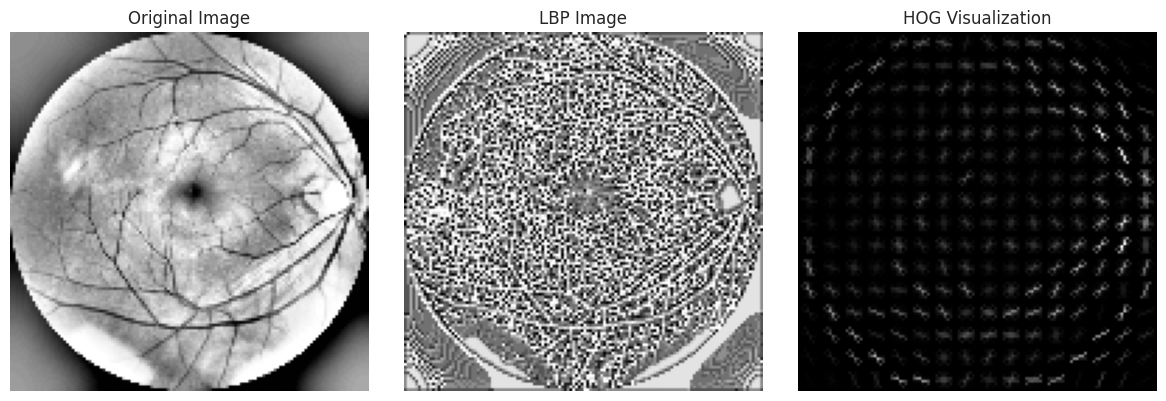

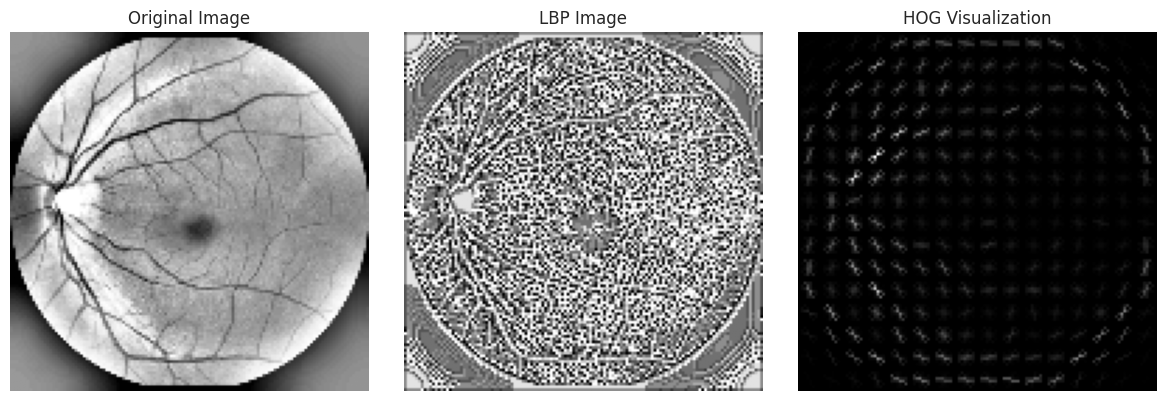

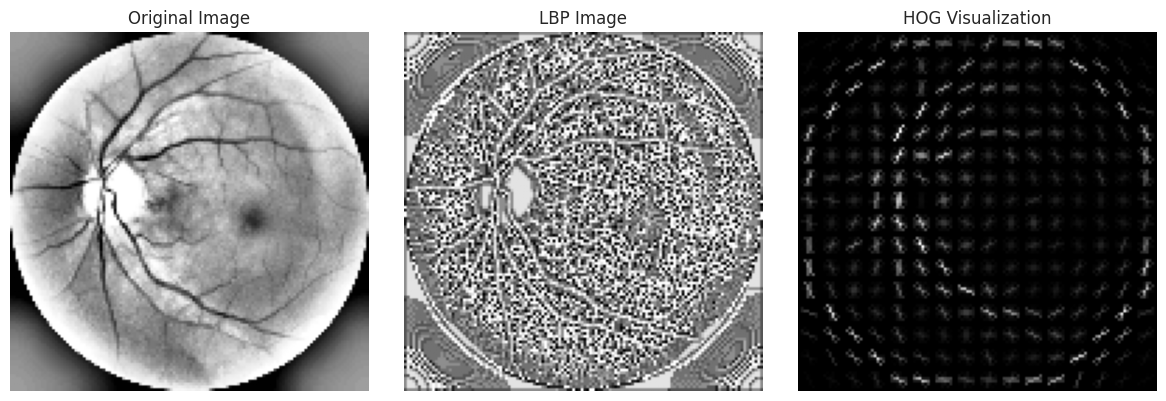

In [44]:
for i in range(3):
    image_feature_engineering(df["images_preprocessed"][i], visualize=True)

In [45]:
# 1. Split Data (Note: PCA will fit on the NEW feature set)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(
    df, x_column="engineered_features", y_column="has_glaucoma", n_components=1500
)

Shape of X (Features): (8621, 7273)
Shape of y (Labels): (8621,)
Fitting feature pipeline
Original Feature Count: 7273
Reduced Feature Count: 1500
Transforming validation features
Transforming test features
Shape of X_train (Train Features): (5172, 1500)
Shape of X_val (Validation Features): (1724, 1500)
Shape of X_test (Test Features): (1725, 1500)
Shape of y_train (Train Labels): (5172,)
Shape of y_val (Validation Labels): (1724,)
Shape of y_test (Test Labels): (1725,)


Training model | Logistic Regression (GPU) - Feature Engineering Approach
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.3s
[CV] END .................................C=0.01, penalty=l2; total time=   0.2s
[CV] END .................................C=0.01, penalty=l2; total time=   0.2s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.3s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.3s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.3s
[CV] END ....................................C=1, penalty=l2; total time=   0.4s
[CV] END ....................................C=1, penalty=l2; total time=   0.5s
[CV] END ....................................C=1, penalty=l2; total time=   0.4s
[CV] END ...................................C=10, penalty=l2; total time=   0.6s
[CV] END ...................................C=10, penalt

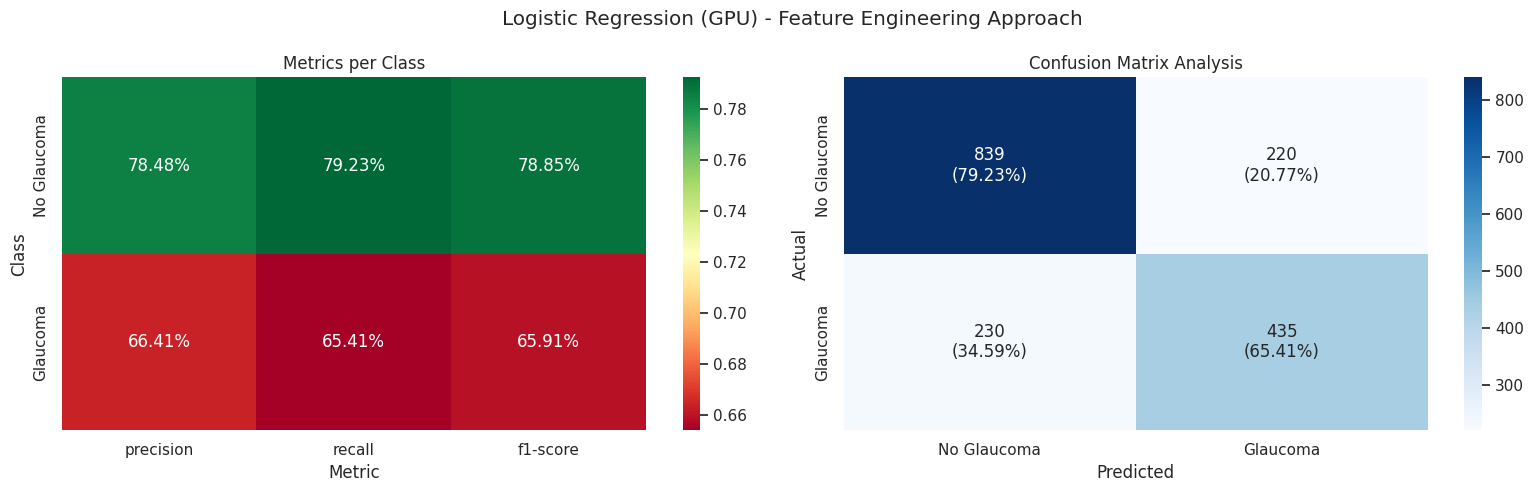

Training model | SVC (GPU) - Feature Engineering Approach
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.6s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.6s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.6s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.7s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.7s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.7s
[CV] END ..............C=1, class_weight=None, kernel=linear; total time=   0.8s
[CV] END ..............C=1, class_weight=None, kernel=linear; total time=   0.8s
[CV] END ..............C=1, class_weight=None, kernel=linear; total time=   0.8s
[CV] END ..........C=1, class_weight=balanced, kernel=linear; total time=   0.8s
[CV] END ..........C=1, class_weight=balanced, kernel=linear; total time

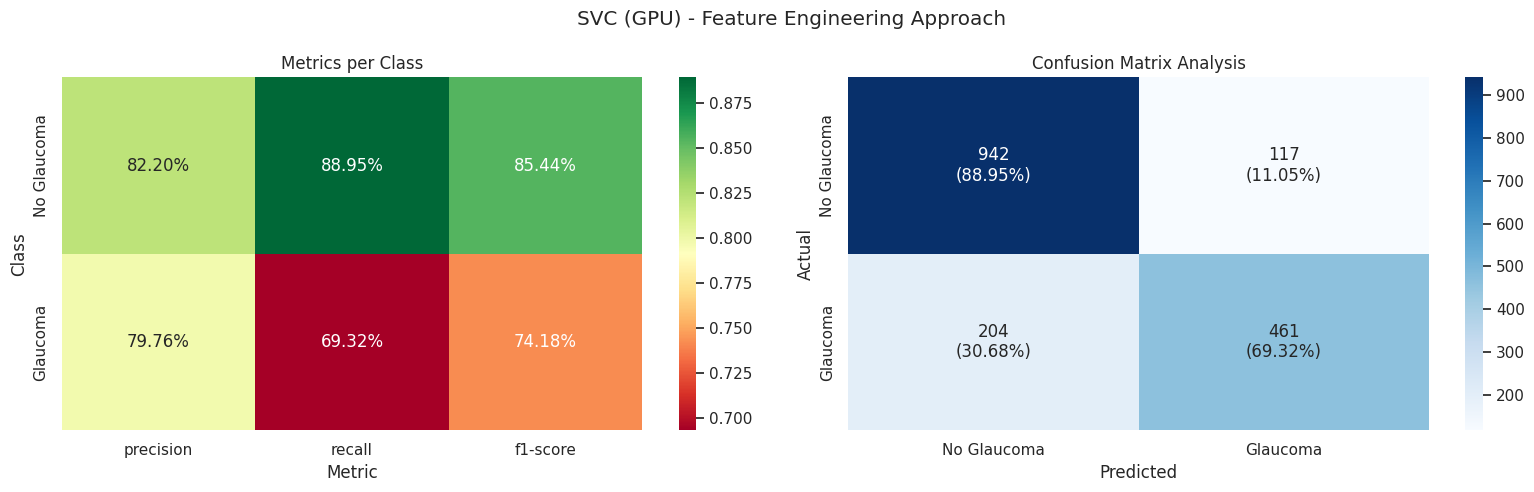

Training model | KNN (GPU) - Feature Engineering Approach
Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ..metric=euclidean, n_neighbors=25, weights=uniform; total time=   0.1s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ..metric=euclidean, n_neighbors=25, weights=uniform; total time=   0.1s
Unused keyword parameter: n_jobs during cuML estimator in

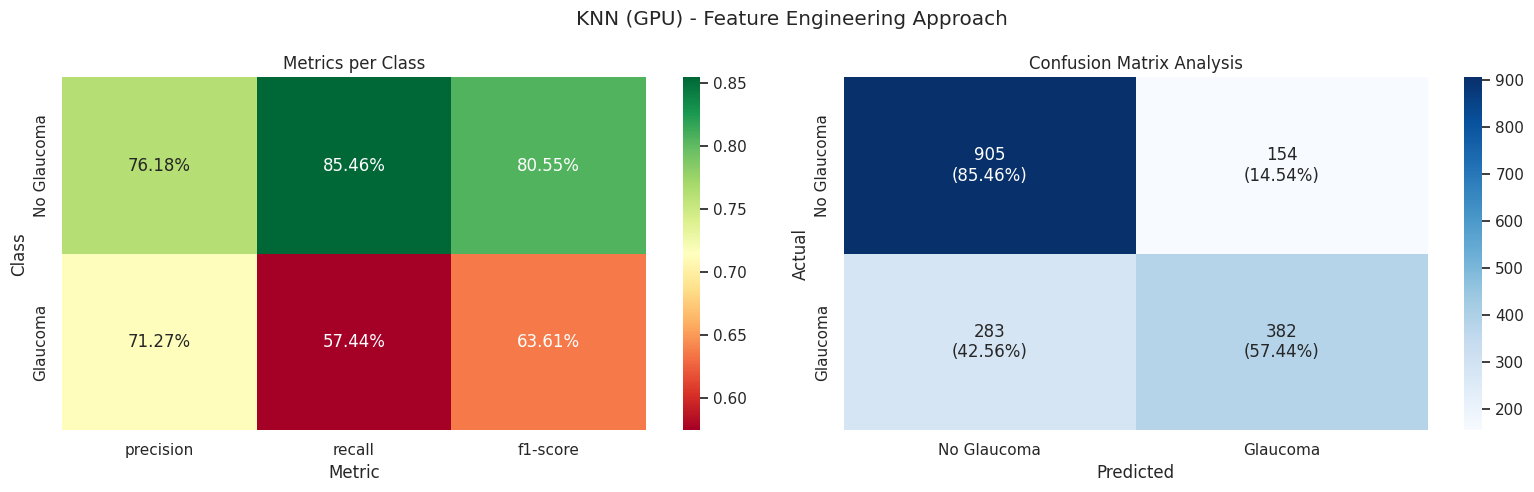

Training model | Random Forest (GPU) - Feature Engineering Approach
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .....................max_depth=10, n_estimators=300; total time=   1.0s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.9s
[CV] END .....................max_depth=15, n_estimators=300; total time=   1.2s
[CV] END .....................max_depth=15, n_estimators=300; total time=   1.2s
[CV] END .....................max_depth=15, n_estimators=300; total time=   1.2s
Computing predictions | Random Forest (GPU) - Feature Engineering Approach
Classification Report | Random Forest (GPU) - Feature Engineering Approach
              precision    recall  f1-score   support

 No Glaucoma       0.63      0.99      0.77      1059
    Glaucoma       0.76      0.06      0.11       665

    accuracy                           0.63      1724
   macro avg       

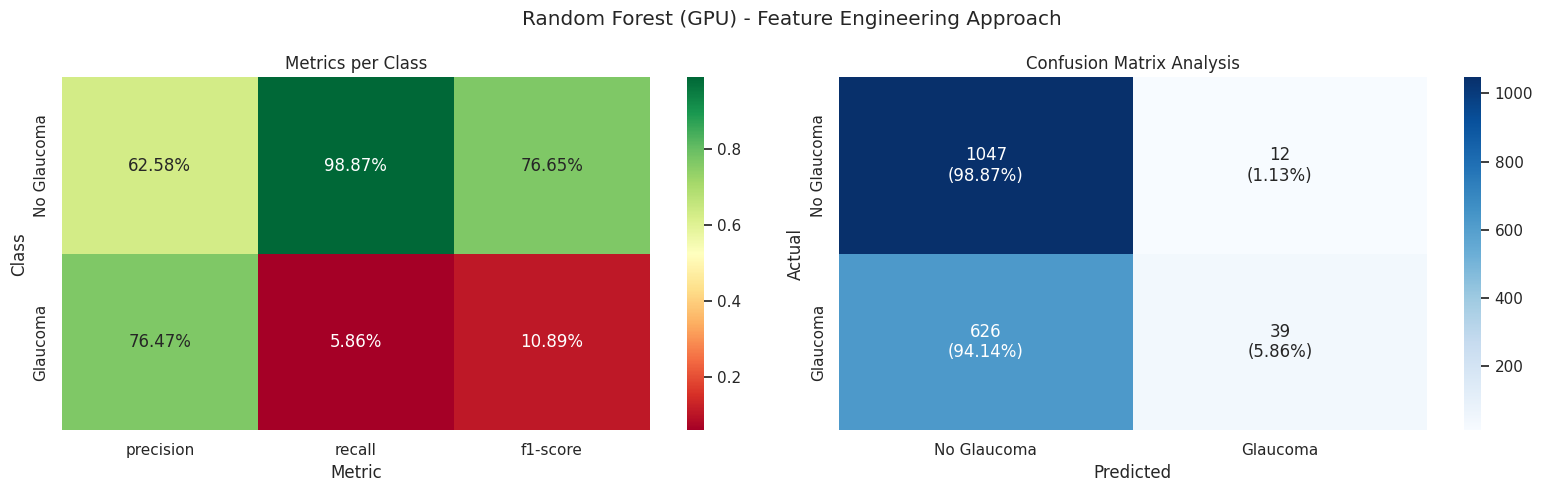

Training model | XGBoost (GPU) - Feature Engineering Approach
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=3, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=3, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=3, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_est

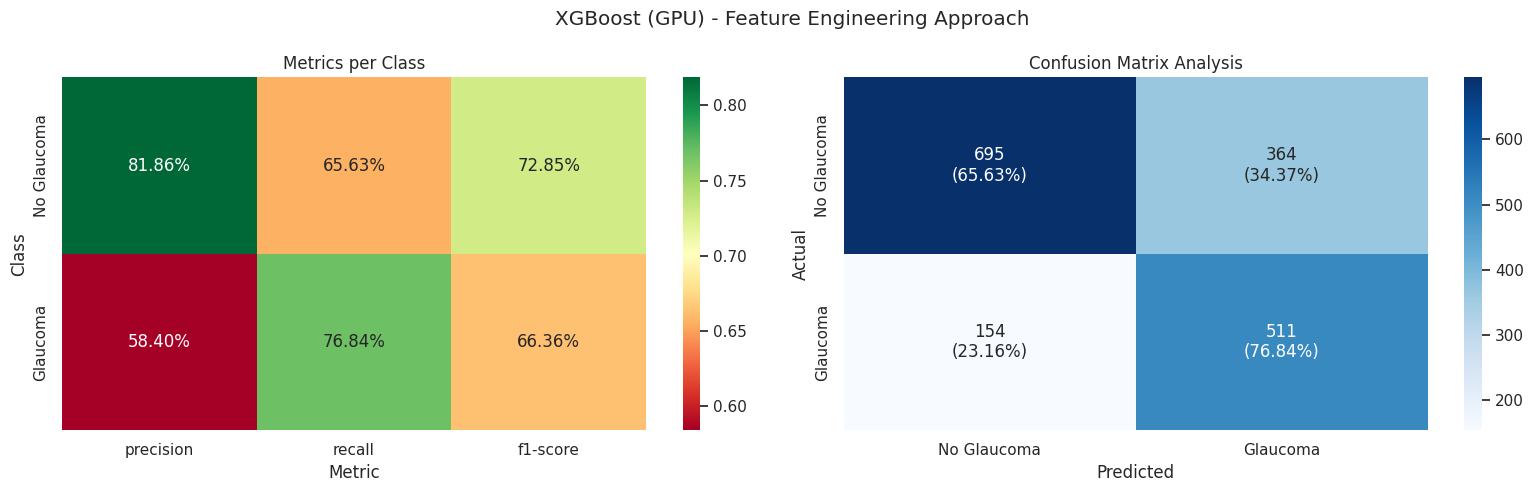

In [46]:
# 2. Train Models
models = models_factory()
for model, title in models:
    model, y_pred, report_dict = train_evaluate_model(
        model,
        X_train,
        X_val,
        y_train,
        y_val,
        title=title + " - Feature Engineering Approach",
    )
    results["engineered_features"].append((title, model, y_pred, report_dict))

## 6. Experiment 3: ROI Localization (The "Sniper" Approach)

Analyzing the entire fundus image (Experiment 2) introduces **noise**: peripheral retina, eyelashes, and artifacts irrelevant to Glaucoma.

**Medical Fact:** Glaucoma is characterized by the degradation of the **Optic Disc** (cupping).
**Hypothesis:** If we automatically detect and crop *only* the Optic Disc, our classical models can focus their limited capacity on the most relevant pixels.

### The Algorithm: Vessel Convergence
How do we find the Optic Disc without Deep Learning?
1.  **Vessel Detection:** Blood vessels appear as dark, thin structures. We use **Top-Hat Morphology** to highlight them.
2.  **Density Mapping:** Vessels radiate *out* from the optic disc like spokes on a wheel. Therefore, the region with the highest *density* of vessels is the Optic Disc.
3.  **Heatmap Localization:** We multiply the vessel map by the intensity map (since the disc is also the brightest region) to create a "Probability Heatmap."
4.  **Centroid Crop:** We find the center of this heatmap and crop a 64x64 patch around it.

In [47]:
def _plot_crop_steps(steps_list):
    """
    Visualization helper for the ROI detection process.
    """
    num_steps = len(steps_list)
    fig, axes = plt.subplots(1, num_steps, figsize=(4 * num_steps, 5))
    if num_steps == 1:
        axes = [axes]

    for idx, (title, img, point, cmap) in enumerate(steps_list):
        ax = axes[idx]
        ax.imshow(img, cmap=cmap)

        if point is not None:
            # Draw a crosshair to show the detected center
            ax.scatter([point[0]], [point[1]], c="red", marker="x", s=100, linewidth=2)

        ax.set_title(title, fontsize=10, fontweight="bold")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def crop_optic_disc_vessel_priority(img, crop_size=80, visualize=False):
    """
    Locates the Optic Disc by finding the convergence point of blood vessels.
    Features 'Resolution Invariance': Kernels scale automatically based on image width.
    """
    h, w = img.shape

    # --- 0. Dynamic Kernel Scaling ---
    # We define kernels relative to a reference width of 800px.
    # If img is 1600px, kernels double in size to detect features of the same physical size.
    scale = w / 800.0

    # Ensure kernels are odd integers and at least 3
    k_vessel = max(3, int(15 * scale)) | 1
    k_blur_density = max(3, int(41 * scale)) | 1
    k_blur_heat = max(3, int(31 * scale)) | 1

    # --- STEP 1: Elliptical Safe Zone ---
    # We ignore the extreme black borders of the fundus image
    _, thresh = cv2.threshold(img, 15, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return img, (w // 2, h // 2), img, img

    largest_cnt = max(contours, key=cv2.contourArea)
    ((cx, cy), radius) = cv2.minEnclosingCircle(largest_cnt)

    mask = np.zeros_like(img)
    safe_radius_x = max(10, int(radius - (15 * scale)))
    safe_radius_y = max(10, int(radius - (50 * scale)))

    cv2.ellipse(
        mask,
        (int(cx), int(cy)),
        (safe_radius_x, safe_radius_y),
        0,
        0,
        360,
        (255, 255, 255),
        -1,
    )

    # --- STEP 2: Vessel Extraction (Top-Hat) ---
    # Top-Hat transformation highlights bright elements (or dark if inverted)
    # smaller than the structuring element. Excellent for thin vessels.
    vessel_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_vessel, k_vessel))
    vessel_map = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, vessel_kernel)

    # --- STEP 3: Density Calculation ---
    # Blur the vessel map to create a "density cloud"
    vessel_density = cv2.GaussianBlur(vessel_map, (k_blur_density, k_blur_density), 0)
    vessel_density = cv2.normalize(vessel_density, None, 0, 255, cv2.NORM_MINMAX)

    # --- STEP 4: Combine with Intensity ---
    # The Optic Disc is usually the brightest spot AND has high vessel density.
    combined_score = cv2.multiply(
        img.astype(np.float32), vessel_density.astype(np.float32)
    )
    combined_score = cv2.normalize(
        combined_score, None, 0, 255, cv2.NORM_MINMAX
    ).astype(np.uint8)

    heatmap = cv2.GaussianBlur(combined_score, (k_blur_heat, k_blur_heat), 0)
    masked_heatmap = cv2.bitwise_and(heatmap, heatmap, mask=mask)

    # --- STEP 5: Centroid Logic ---
    # Find the brightest spot in the heatmap
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(masked_heatmap)
    threshold_val = maxVal * 0.70
    _, hotspot_mask = cv2.threshold(
        masked_heatmap, threshold_val, 255, cv2.THRESH_BINARY
    )

    dilate_k = max(3, int(15 * scale)) | 1
    kernel_dilate = np.ones((dilate_k, dilate_k), np.uint8)
    hotspot_mask = cv2.dilate(hotspot_mask, kernel_dilate, iterations=2)

    M = cv2.moments(hotspot_mask)
    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        center_x, center_y = maxLoc

    # --- STEP 6: Crop ---
    half_size = crop_size // 2
    # Pad image to handle cases where the disc is at the very edge
    pad_img = cv2.copyMakeBorder(
        img, half_size, half_size, half_size, half_size, cv2.BORDER_CONSTANT, value=0
    )

    p_cx = center_x + half_size
    p_cy = center_y + half_size
    cropped_img = pad_img[
        p_cy - half_size : p_cy + half_size, p_cx - half_size : p_cx + half_size
    ]

    # --- VISUALIZATION ---
    if visualize:
        steps = [
            ("Original", img, (center_x, center_y), "gray"),
            ("Vessel Map", vessel_map, None, "gray"),
            ("Convergence Heatmap", masked_heatmap, (center_x, center_y), "jet"),
            ("Result Crop", cropped_img, None, "gray"),
        ]
        _plot_crop_steps(steps)

    return cropped_img, (center_x, center_y), vessel_map, masked_heatmap

In [48]:
# 1. Apply Smart Cropping
# We crop to 64x64 px (Standard size for the optic disc)
df["images_preprocessed_roi"] = df["images_preprocessed"].progress_apply(
    lambda x: crop_optic_disc_vessel_priority(x, crop_size=64, visualize=False)[0]
)

  0%|          | 0/8621 [00:00<?, ?it/s]

In [49]:
# 2. Extract Features from the CROPS
# Now LBP and HOG will describe the *Disc* texture, not the background wall.
df["engineered_features_roi"] = df["images_preprocessed_roi"].progress_apply(
    image_feature_engineering
)
df.info()

  0%|          | 0/8621 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   has_glaucoma             8621 non-null   int64 
 1   paths                    8621 non-null   object
 2   images                   8621 non-null   object
 3   simple_features          8621 non-null   object
 4   images_preprocessed      8621 non-null   object
 5   engineered_features      8621 non-null   object
 6   images_preprocessed_roi  8621 non-null   object
 7   engineered_features_roi  8621 non-null   object
dtypes: int64(1), object(7)
memory usage: 538.9+ KB


### Visual Verification of ROI
We check random samples to ensure the algorithm is locking onto the Optic Disc (the bright circle with vertical vessels) and not random noise.

--- Visualizing ROI Detection Steps ---


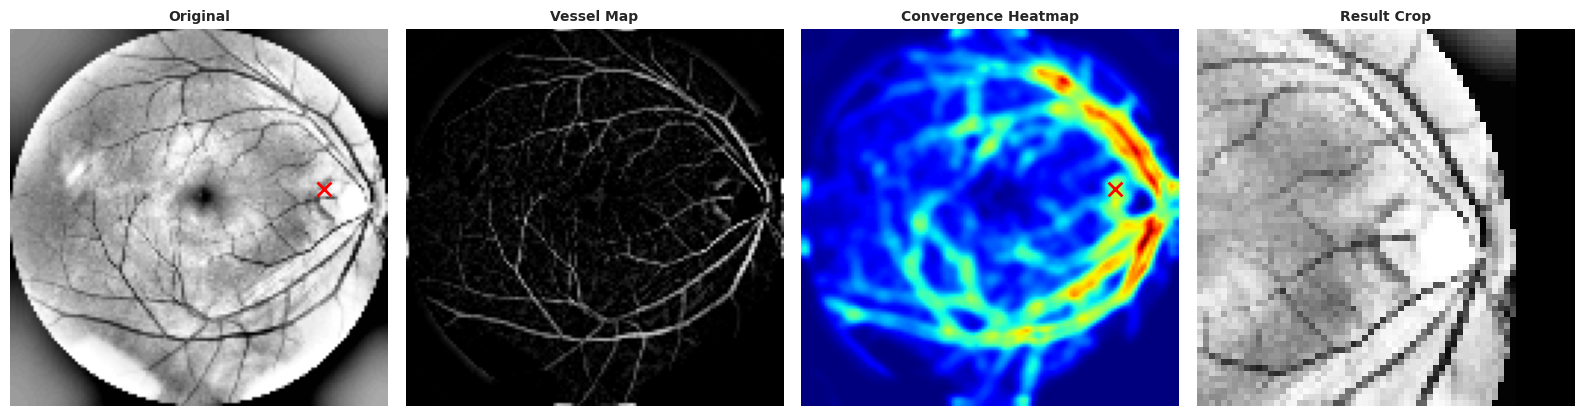

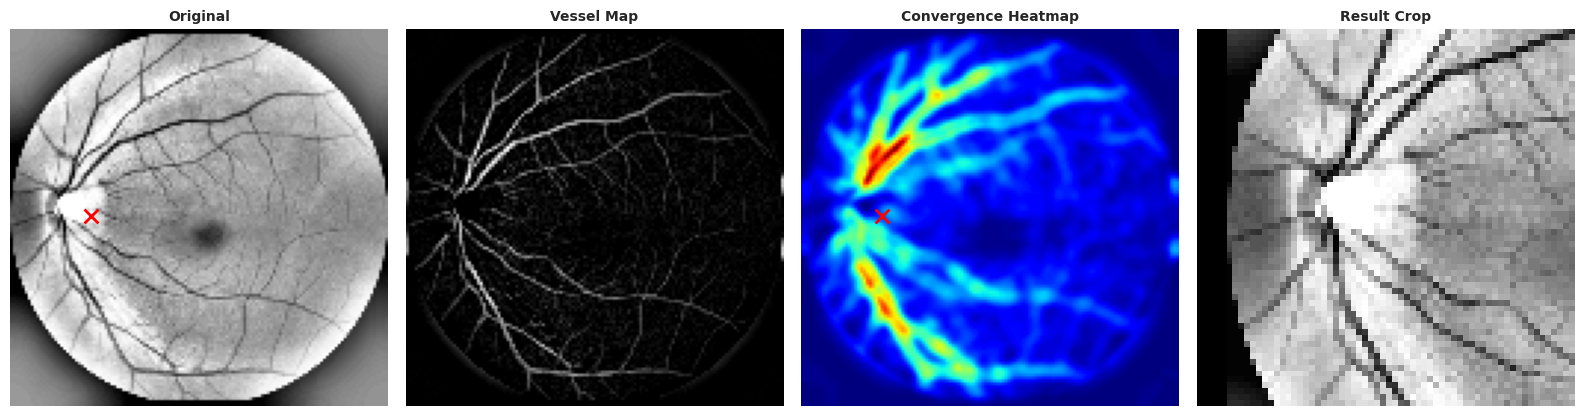

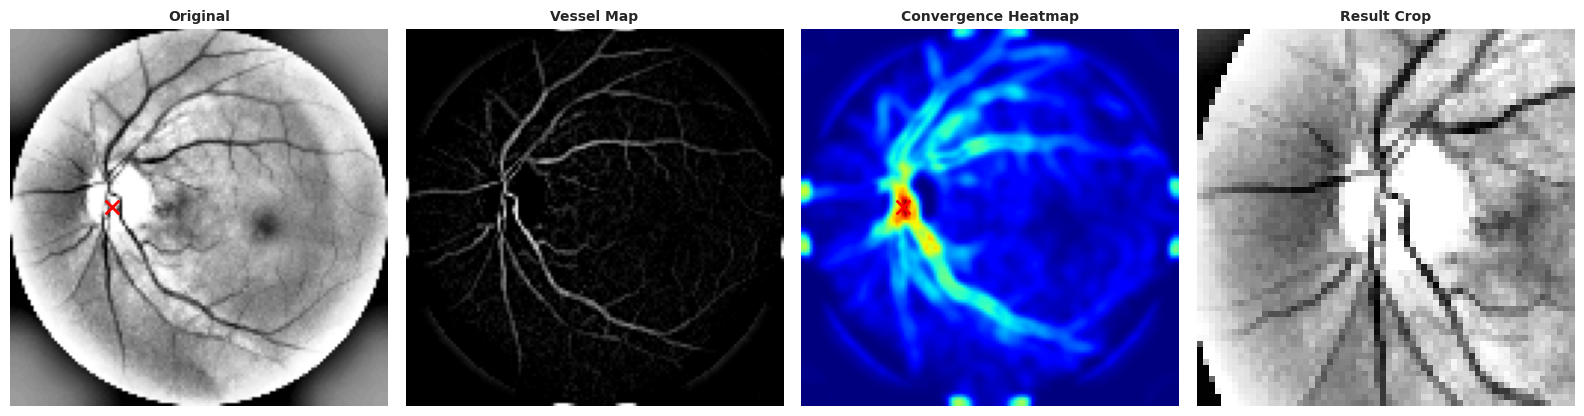

In [50]:
print("--- Visualizing ROI Detection Steps ---")
# Visualize the internal logic (Heatmaps) for the first few images
for i in range(3):
    _ = crop_optic_disc_vessel_priority(df["images_preprocessed"][i], crop_size=64, visualize=True)

--- Comparing Full Image vs ROI ---


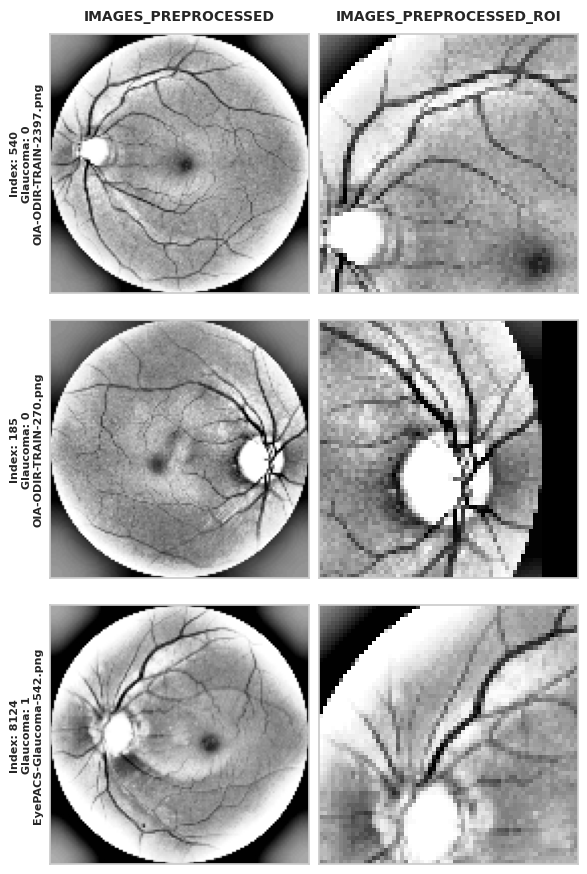

In [55]:
print("--- Comparing Full Image vs ROI ---")
plot_parallel_columns(df, ["images_preprocessed", "images_preprocessed_roi"], num_samples=3)

In [53]:
# 1. Split Data (PCA fits on ROI features)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(
    df, x_column="engineered_features_roi", y_column="has_glaucoma", n_components=500
)

Shape of X (Features): (8621, 1641)
Shape of y (Labels): (8621,)
Fitting feature pipeline
Original Feature Count: 1641
Reduced Feature Count: 500
Transforming validation features
Transforming test features
Shape of X_train (Train Features): (5172, 500)
Shape of X_val (Validation Features): (1724, 500)
Shape of X_test (Test Features): (1725, 500)
Shape of y_train (Train Labels): (5172,)
Shape of y_val (Validation Labels): (1724,)
Shape of y_test (Test Labels): (1725,)


Training model | Logistic Regression (GPU) - Feature Engineering ROI Approach
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.1s
[CV] END ....................................C=1, penalty=l2; total time=   0.1s
[CV] END ....................................C=1, penalty=l2; total time=   0.1s
[CV] END ....................................C=1, penalty=l2; total time=   0.1s
[CV] END ...................................C=10, penalty=l2; total time=   0.1s
[CV] END ...................................C=10, pe

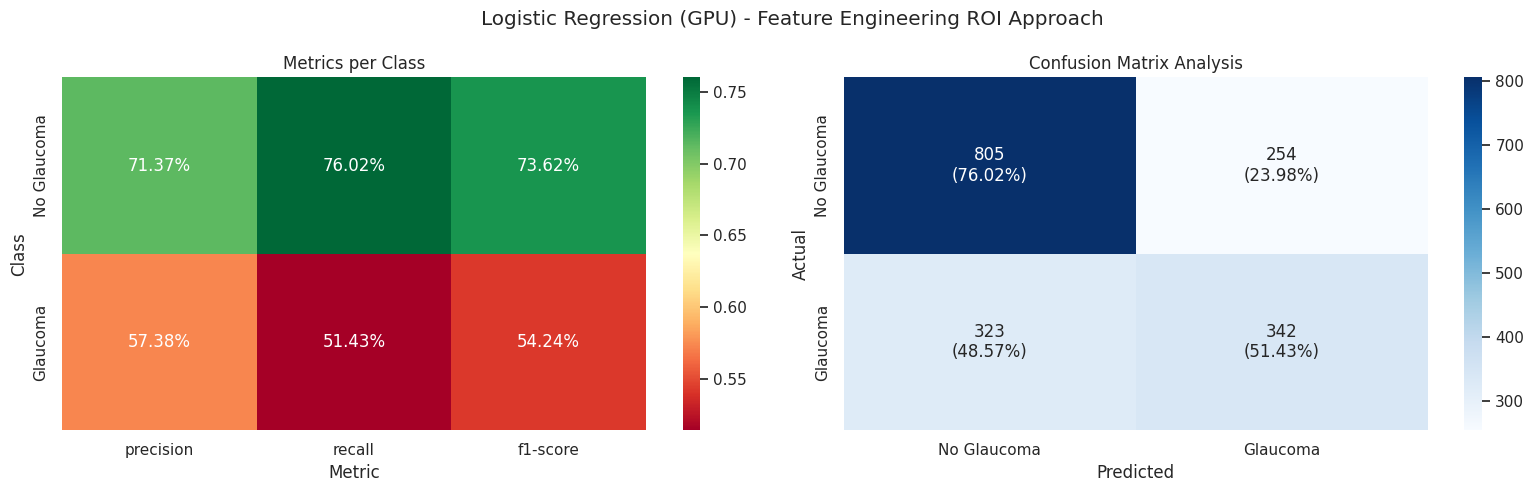

Training model | SVC (GPU) - Feature Engineering ROI Approach
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.3s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.3s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.3s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END ..............C=1, class_weight=None, kernel=linear; total time=   0.4s
[CV] END ..............C=1, class_weight=None, kernel=linear; total time=   0.4s
[CV] END ..............C=1, class_weight=None, kernel=linear; total time=   0.4s
[CV] END ..........C=1, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END ..........C=1, class_weight=balanced, kernel=linear; total 

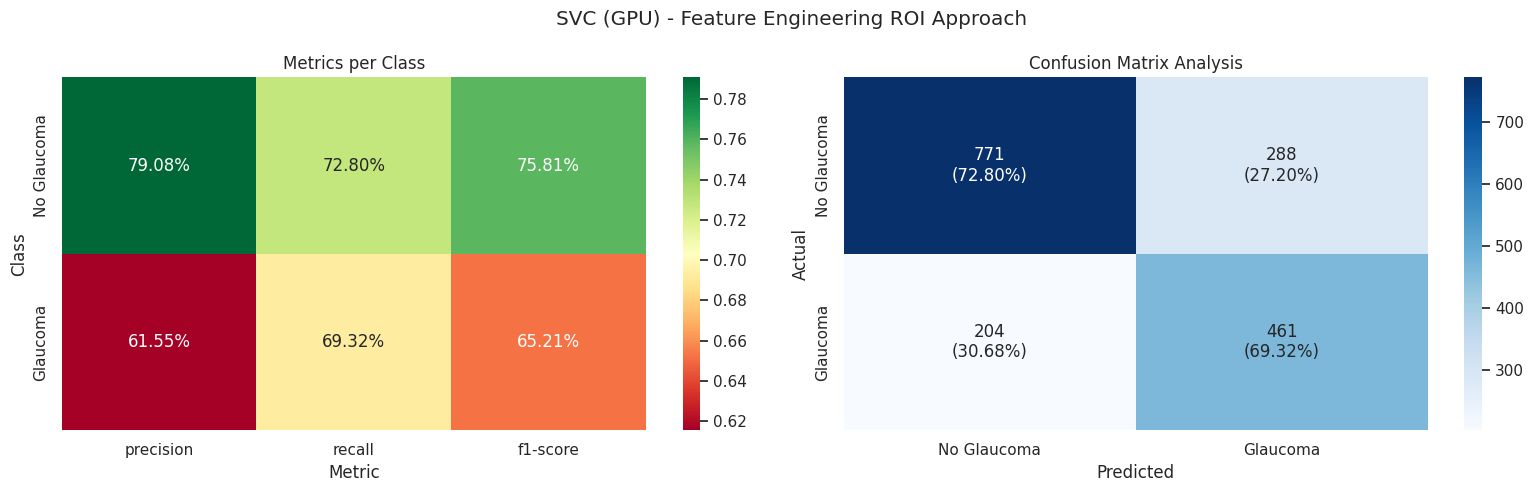

Training model | KNN (GPU) - Feature Engineering ROI Approach
Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ..metric=euclidean, n_neighbors=25, weights=uniform; total time=   0.0s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ..metric=euclidean, n_neighbors=25, weights=uniform; total time=   0.0s
Unused keyword parameter: n_jobs during cuML estimato

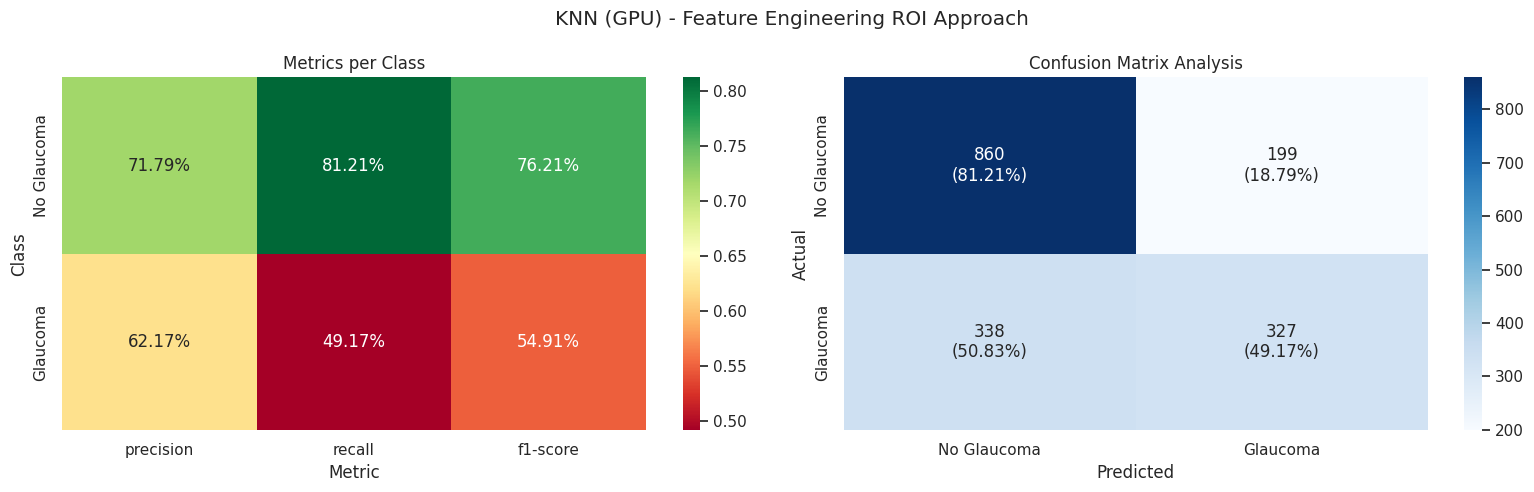

Training model | Random Forest (GPU) - Feature Engineering ROI Approach
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.7s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.7s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.7s
[CV] END .....................max_depth=15, n_estimators=300; total time=   1.0s
[CV] END .....................max_depth=15, n_estimators=300; total time=   0.9s
[CV] END .....................max_depth=15, n_estimators=300; total time=   0.9s
Computing predictions | Random Forest (GPU) - Feature Engineering ROI Approach
Classification Report | Random Forest (GPU) - Feature Engineering ROI Approach
              precision    recall  f1-score   support

 No Glaucoma       0.62      0.99      0.77      1059
    Glaucoma       0.79      0.04      0.07       665

    accuracy                           0.63      1724
   macr

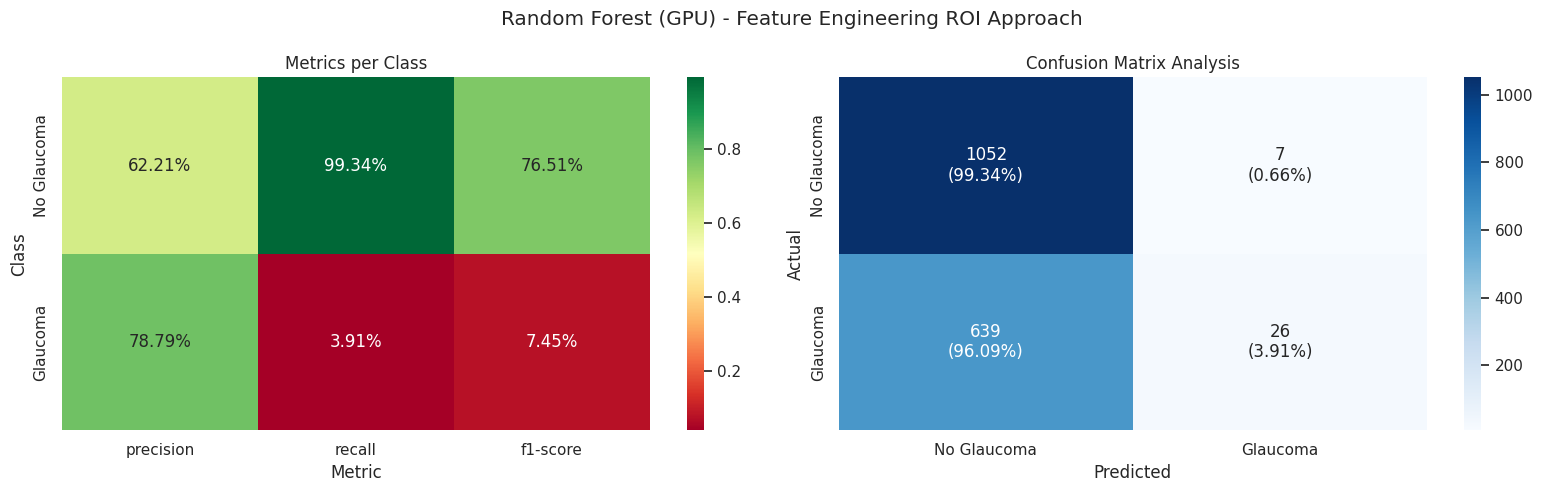

Training model | XGBoost (GPU) - Feature Engineering ROI Approach
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=3, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=3, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=3, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n

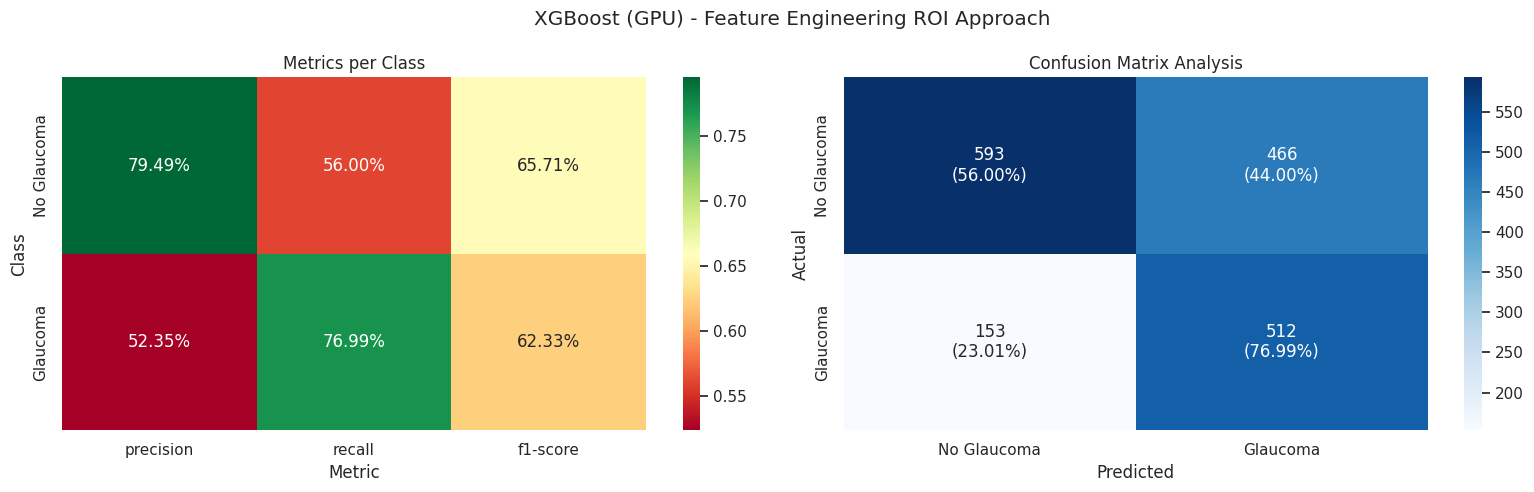

In [54]:
# 2. Train Models
models = models_factory()
for model, title in models:
    model, y_pred, report_dict = train_evaluate_model(
        model,
        X_train,
        X_val,
        y_train,
        y_val,
        title=title + " - Feature Engineering ROI Approach",
    )
    results["engineered_features_roi"].append((title, model, y_pred, report_dict))

## 7. Experiment 4: The Holistic "Kitchen Sink" Approach

In our final experiment, we combine the strengths of all previous approaches and add **Domain-Specific Logic**. Glaucoma isn't just a texture problem; it's a physiological one.

### The Strategy: Color + Structure + Heuristics
We define a comprehensive feature extractor that operates in two parallel paths:

#### Path A: Physiology (Color & Brightness)
* **Pallor Detection:** As nerve fibers die, the optic disc loses its pinkish hue and becomes white (pallor). We detect this utilizing the **'Saturation' (HSV)** and **'a-channel' (LAB)**.
* **Cup-to-Disc Ratio (CDR):** The most critical clinical indicator. We estimate the "Cup" (brightest center) and "Disc" (functional area) sizes using dynamic thresholding to calculate an approximate CDR. [Image of Glaucoma Cup to Disc Ratio diagram]

#### Path B: Advanced Texture (Frequency Analysis)
* **Gabor Filters:** Unlike LBP (which looks at neighbors), Gabor filters analyze the image in the **Frequency Domain**. They are excellent at detecting directional patterns, such as the radiating nerve fibers that disappear in Glaucoma. [Image of Gabor filter visual patterns]
* **Multi-Scale Analysis:** We run LBP and GLCM at multiple radii (1, 3, 5) to capture both fine details (micro-vessels) and coarse details (overall shape).

In [56]:
def extract_glaucoma_features(img_rgb, visualize=False):
    """
    A comprehensive feature extractor combining Color, Texture, and Structural heuristics.
    Returns a concatenated 1D vector.
    """
    EPSILON = 1e-6  # To prevent division by zero
    RESIZE_DIM = (128, 128)

    # Resize immediately to standardize feature counts (HOG/Gabor depend on size)
    img = cv2.resize(img_rgb, RESIZE_DIM)

    # Lists to hold feature arrays
    feats_color = []
    feats_structure = []

    # =========================================================================
    # PATH A: COLOR & INTENSITY (Raw Image)
    # Detects: Pallor (Whitening), Cup-to-Disc Ratio (Brightness)
    # =========================================================================

    # A1. Channel Statistics
    # Green is best for contrast, Red usually correlates with vascularity
    R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    feats_color.extend(
        [
            np.mean(G),
            np.std(G),
            skew(G.flatten()),  # Green Intensity
            np.mean(R),
            np.std(R),  # Red Intensity
        ]
    )

    # A2. Color Space Transformations (Pallor Detection)
    # HSV: Saturation drops in glaucomatous cups (whiter = less saturated)
    hsv = rgb2hsv(img)
    S_channel = hsv[:, :, 1]
    feats_color.extend([np.mean(S_channel), np.std(S_channel)])

    # LAB: 'a' channel represents Red-Green balance. Lower 'a' = less red (pallor).
    lab = rgb2lab(img)
    a_channel = lab[:, :, 1]
    feats_color.extend([np.mean(a_channel), np.std(a_channel)])

    # A3. Heuristic Cup-to-Disc Ratio (CDR)
    # Approximation: "Cup" is the brightest cluster. "Disc" is the functional area.
    # We threshold the Green channel.
    flat_g = G.flatten()
    # Threshold for Cup: Top 2.5% brightest pixels (approximate cup area)
    cup_thresh = np.percentile(flat_g, 97.5)
    # Threshold for Disc: Pixels above black background (approx > 15 intensity)
    disc_thresh = 15

    cup_area = np.sum(G > cup_thresh)
    disc_area = np.sum(G > disc_thresh)

    cdr_approx = cup_area / (disc_area + EPSILON)
    feats_color.append(cdr_approx)

    # =========================================================================
    # PATH B: STRUCTURE & TEXTURE (Preprocessed Image)
    # Detects: Vessel shifting, Nerve Fiber Layer defects
    # =========================================================================

    # B1. Preprocessing (Graham's Method)
    # 1. Extract Green -> 2. Gaussian Blur -> 3. AddWeighted -> 4. CLAHE
    img_green = img[:, :, 1]
    img_blurred = cv2.GaussianBlur(img_green, (0, 0), 10)
    img_corrected = cv2.addWeighted(img_green, 4, img_blurred, -4, 128)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_proc = clahe.apply(img_corrected)  # This is our "Structure Image"

    # B2. Vessel Density
    # Using Canny edge detection to find vessels
    edges = cv2.Canny(img_proc, 50, 150)
    vessel_density = np.sum(edges) / (edges.size + EPSILON)
    feats_structure.append(vessel_density)

    # B3. Multi-Scale LBP
    # Captures fine texture (nerves) and coarse texture (vessels)
    for radius in [1, 3]:
        n_points = 8 * radius
        lbp = local_binary_pattern(img_proc, n_points, radius, method="uniform")
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(
            lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True
        )
        feats_structure.extend(hist)

    # B4. Multi-Scale GLCM
    # Captures homogeneity and contrast at different pixel distances
    # Distance 1: Immediate texture. Distance 5: Larger patterns.
    glcm = graycomatrix(
        img_proc,
        distances=[1, 5],
        angles=[0, np.pi / 2],
        levels=256,
        symmetric=True,
        normed=True,
    )

    for prop in ["contrast", "energy", "homogeneity", "correlation"]:
        # flattens properties for all distances/angles
        feats_structure.extend(graycoprops(glcm, prop).flatten())

    # B5. HOG (Histogram of Oriented Gradients)
    # Describes vessel orientation/displacement
    # Reduced pixels_per_cell to 8x8 for better resolution on small ROI
    hog_feats = hog(
        img_proc,
        orientations=8,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        visualize=False,
    )
    feats_structure.extend(hog_feats)

    # B6. Gabor Filters (Advanced Texture)
    # Good for detecting directional patterns (like nerve fibers)
    # We create a bank of filters at different orientations
    frequencies = [0.1, 0.3]  # Low and High frequency
    thetas = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]  # 0, 45, 90, 135 degrees

    for freq in frequencies:
        for theta in thetas:
            # Create kernel
            kernel = gabor_kernel(freq, theta=theta)
            # Filter the image (real part is sufficient for texture energy)
            # We use the structure image (img_proc)
            filtered = ndi.convolve(
                img_proc.astype(float), np.real(kernel), mode="wrap"
            )

            # Compute stats of the response
            feats_structure.extend([np.mean(filtered), np.var(filtered)])

    # =========================================================================
    # FINAL CONCATENATION
    # =========================================================================

    # Combine list of scalars and arrays into one flat vector
    all_features = np.concatenate([np.array(feats_color), np.array(feats_structure)])

    if visualize:
        print(f"Color Features: {len(feats_color)}")
        print(f"Structure Features: {len(feats_structure)}")
        print(f"Total Features: {len(all_features)}")

    return all_features

In [57]:
print("Extracting Advanced Features (Color + Structure + Gabor + HOG)...")
df["advanced_features"] = df["images"].progress_apply(extract_glaucoma_features)
df.info()

Extracting Advanced Features (Color + Structure + Gabor + HOG)...


  0%|          | 0/8621 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   has_glaucoma             8621 non-null   int64 
 1   paths                    8621 non-null   object
 2   images                   8621 non-null   object
 3   simple_features          8621 non-null   object
 4   images_preprocessed      8621 non-null   object
 5   engineered_features      8621 non-null   object
 6   images_preprocessed_roi  8621 non-null   object
 7   engineered_features_roi  8621 non-null   object
 8   advanced_features        8621 non-null   object
dtypes: int64(1), object(8)
memory usage: 606.3+ KB


In [59]:
# 1. Split Data
X_train, X_val, X_test, y_train, y_val, y_test = data_split(
    df, x_column="advanced_features", y_column="has_glaucoma", n_components=1500
)

Shape of X (Features): (8621, 7279)
Shape of y (Labels): (8621,)
Fitting feature pipeline
Original Feature Count: 7279
Reduced Feature Count: 1500
Transforming validation features
Transforming test features
Shape of X_train (Train Features): (5172, 1500)
Shape of X_val (Validation Features): (1724, 1500)
Shape of X_test (Test Features): (1725, 1500)
Shape of y_train (Train Labels): (5172,)
Shape of y_val (Validation Labels): (1724,)
Shape of y_test (Test Labels): (1725,)


Training model | Logistic Regression (GPU) - Advanced Feature Engineering Approach
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.2s
[CV] END .................................C=0.01, penalty=l2; total time=   0.2s
[CV] END .................................C=0.01, penalty=l2; total time=   0.2s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.3s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.3s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.3s
[CV] END ....................................C=1, penalty=l2; total time=   0.4s
[CV] END ....................................C=1, penalty=l2; total time=   0.5s
[CV] END ....................................C=1, penalty=l2; total time=   0.4s
[CV] END ...................................C=10, penalty=l2; total time=   0.7s
[CV] END ...................................C=1

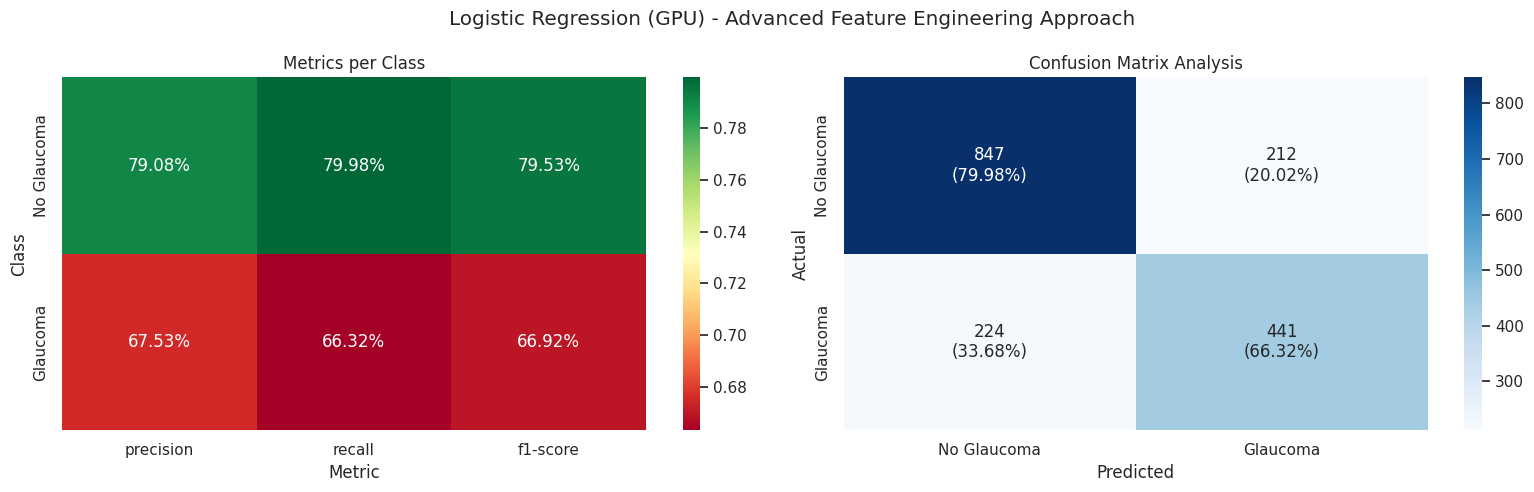

Training model | SVC (GPU) - Advanced Feature Engineering Approach
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.6s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.6s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.6s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.7s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.7s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.7s
[CV] END ..............C=1, class_weight=None, kernel=linear; total time=   0.8s
[CV] END ..............C=1, class_weight=None, kernel=linear; total time=   0.8s
[CV] END ..............C=1, class_weight=None, kernel=linear; total time=   0.8s
[CV] END ..........C=1, class_weight=balanced, kernel=linear; total time=   0.8s
[CV] END ..........C=1, class_weight=balanced, kernel=linear; t

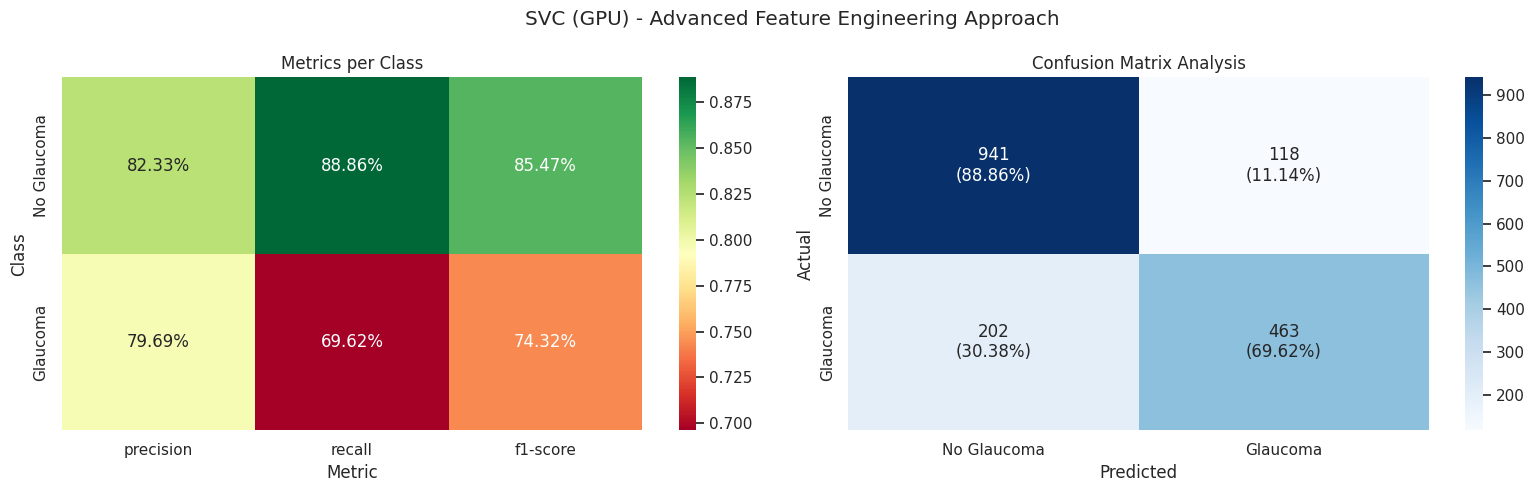

Training model | KNN (GPU) - Advanced Feature Engineering Approach
Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ..metric=euclidean, n_neighbors=25, weights=uniform; total time=   0.1s
Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ..metric=euclidean, n_neighbors=25, weights=uniform; total time=   0.1s
Unused keyword parameter: n_jobs during cuML est

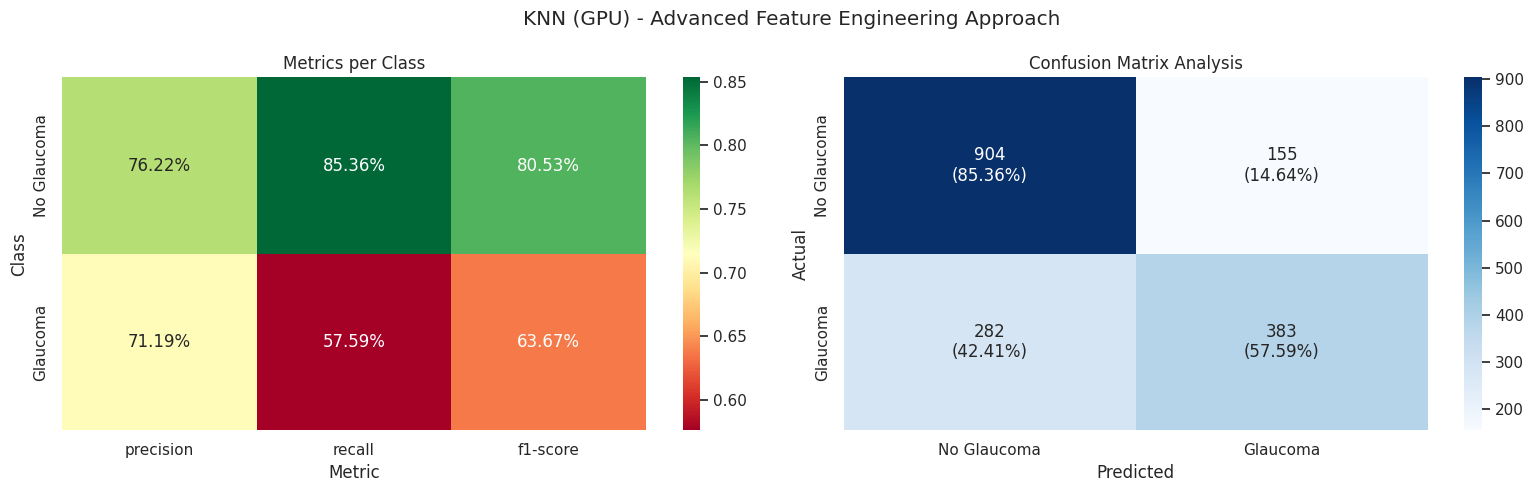

Training model | Random Forest (GPU) - Advanced Feature Engineering Approach
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .....................max_depth=10, n_estimators=300; total time=   1.0s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.9s
[CV] END .....................max_depth=15, n_estimators=300; total time=   1.2s
[CV] END .....................max_depth=15, n_estimators=300; total time=   1.2s
[CV] END .....................max_depth=15, n_estimators=300; total time=   1.2s
Computing predictions | Random Forest (GPU) - Advanced Feature Engineering Approach
Classification Report | Random Forest (GPU) - Advanced Feature Engineering Approach
              precision    recall  f1-score   support

 No Glaucoma       0.62      0.99      0.77      1059
    Glaucoma       0.79      0.05      0.09       665

    accuracy                           0.63   

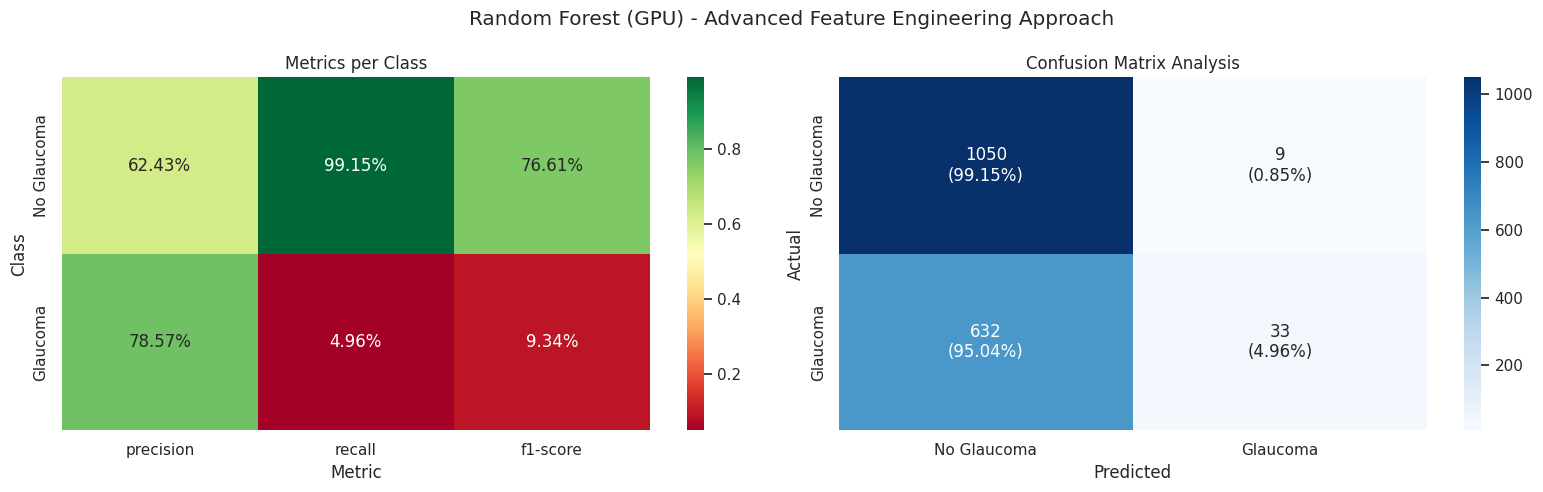

Training model | XGBoost (GPU) - Advanced Feature Engineering Approach
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=3, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=3, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=3, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth

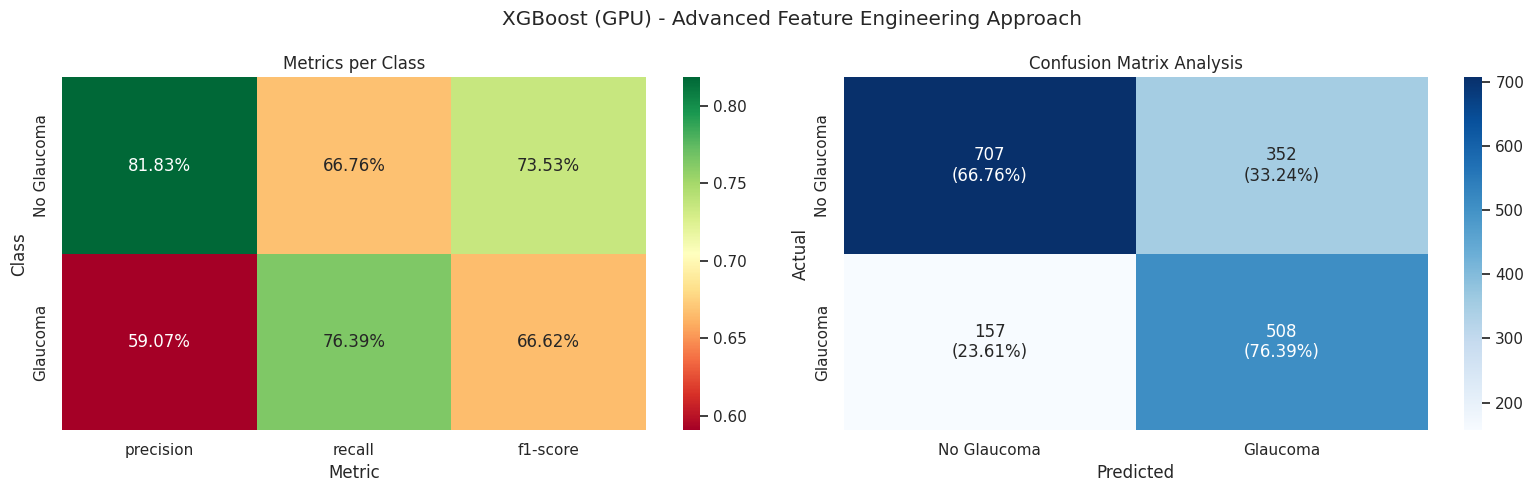

In [60]:
# 2. Train Models
models = models_factory()

for model, title in models:
    model, y_pred, report_dict = train_evaluate_model(
        model,
        X_train,
        X_val,
        y_train,
        y_val,
        title=title + " - Advanced Feature Engineering Approach",
    )
    results["advanced_features"].append((title, model, y_pred, report_dict))

## 8. Comparative Analysis & Results

We have completed the "Tournament of Models," testing 4 distinct feature engineering strategies across 5 different classification algorithms.

To determine the best approach, we aggregate the metrics (Precision, Recall, F1-Score, Accuracy) from all experiments into a single leaderboard.

**Evaluation Criteria:**
* **Primary Metric:** `F1-Score` (Weighted). Since the dataset is imbalanced, Accuracy can be misleading. F1 provides a balance between Precision and Recall.
* **Clinical Relevance:** We also look closely at `Recall` (Sensitivity). In medical screening, **False Negatives** (telling a sick patient they are healthy) are dangerous. High recall is often preferred even at the cost of some precision.

In [61]:
rows = []
for approach, model_results in results.items():
    for model_name, model_obj, val_preds, report in model_results:
        # Extract overall metrics (weighted avg or macro avg)
        if "weighted avg" in report:
            metrics = report["weighted avg"]
        elif "macro avg" in report:
            metrics = report["macro avg"]
        else:
            continue

        row = {
            "approach": approach,
            "model": model_name,
            "pair": f"{approach}|{model_name}",
            "precision": metrics.get("precision", 0),
            "recall": metrics.get("recall", 0),
            "f1-score": metrics.get("f1-score", 0),
            "support": metrics.get("support", 0),
            "accuracy": report.get("accuracy", 0),
        }
        rows.append(row)

df_results = pd.DataFrame(rows)

# Sort by f1-score descending
df_results.sort_values("f1-score", ascending=False, inplace=True)
df_results.reset_index(
    drop=True, inplace=True
)

# Add ranking
df_results.insert(0, "rank", range(1, len(df_results) + 1))
df_results.head(5)

rank             approach                model  \
0     1      simple_features        XGBoost (GPU)   
1     2    advanced_features            SVC (GPU)   
2     3  engineered_features            SVC (GPU)   
3     4      simple_features            SVC (GPU)   
4     5      simple_features  Random Forest (GPU)   

                                  pair  precision    recall  f1-score  \
0        simple_features|XGBoost (GPU)   0.825890  0.825986  0.825937   
1          advanced_features|SVC (GPU)   0.813100  0.814385  0.811669   
2        engineered_features|SVC (GPU)   0.812573  0.813805  0.810962   
3            simple_features|SVC (GPU)   0.808324  0.809745  0.808624   
4  simple_features|Random Forest (GPU)   0.822647  0.808585  0.797811   

   support  accuracy  
0   1724.0  0.825986  
1   1724.0  0.814385  
2   1724.0  0.813805  
3   1724.0  0.809745  
4   1724.0  0.808585

In [62]:
metrics = ["precision", "recall", "f1-score", "accuracy"]
best_pairs = {}

# Find best for each individual metric
for metric in metrics:
    best_idx = df_results[metric].idxmax()
    best_row = df_results.loc[best_idx]
    best_pairs[metric] = {
        "pair": best_row["pair"],
        "approach": best_row["approach"],
        "model": best_row["model"],
        "value": best_row[metric],
        "all_metrics": {m: best_row[m] for m in metrics},
    }

# Find overall best (highest f1-score as default, or you can use average rank)
best_overall_idx = df_results["f1-score"].idxmax()
best_overall = df_results.loc[best_overall_idx]
best_pairs["overall"] = {
    "pair": best_overall["pair"],
    "approach": best_overall["approach"],
    "model": best_overall["model"],
    "all_metrics": {m: best_overall[m] for m in metrics},
}

In [63]:
print("=" * 80)
print("BEST APPROACH|MODEL PAIRS")
print("=" * 80)

if "overall" in best_pairs:
    print("\n🏆 OVERALL BEST (by F1-Score):")
    overall = best_pairs["overall"]
    print(f"   Pair: {overall['pair']}")
    print(f"   Metrics: {overall['all_metrics']}")

print("\n📊 BEST BY METRIC:")
for metric in ["precision", "recall", "f1-score", "accuracy"]:
    if metric in best_pairs:
        info = best_pairs[metric]
        print(f"\n   {metric.upper()}:")
        print(f"      Pair: {info['pair']}")
        print(f"      Value: {info['value']:.4f}")
print("\n" + "=" * 80)

BEST APPROACH|MODEL PAIRS

🏆 OVERALL BEST (by F1-Score):
   Pair: simple_features|XGBoost (GPU)
   Metrics: {'precision': np.float64(0.8258904669595404), 'recall': np.float64(0.8259860788863109), 'f1-score': np.float64(0.8259371263454202), 'accuracy': np.float64(0.8259860788863109)}

📊 BEST BY METRIC:

   PRECISION:
      Pair: simple_features|XGBoost (GPU)
      Value: 0.8259

   RECALL:
      Pair: simple_features|XGBoost (GPU)
      Value: 0.8260

   F1-SCORE:
      Pair: simple_features|XGBoost (GPU)
      Value: 0.8259

   ACCURACY:
      Pair: simple_features|XGBoost (GPU)
      Value: 0.8260



## 9. Visualizing the Leaderboard

To make the "winning strategy" obvious, we plot the F1-Scores of all 20 models (4 Approaches × 5 Algorithms) in a single bar chart.

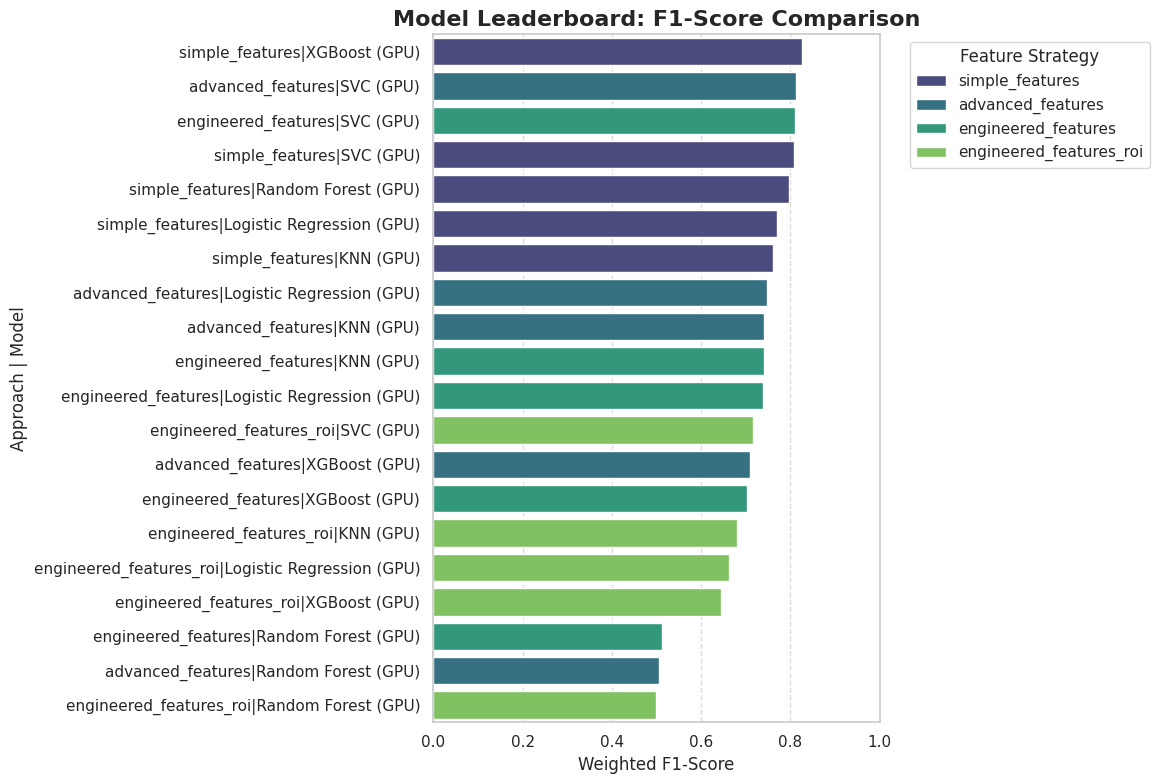

In [64]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_results,
    y="pair",
    x="f1-score",
    hue="approach",
    dodge=False,
    palette="viridis",
)
plt.title("Model Leaderboard: F1-Score Comparison", fontsize=16, fontweight="bold")
plt.xlabel("Weighted F1-Score", fontsize=12)
plt.ylabel("Approach | Model", fontsize=12)
plt.xlim(0, 1.0)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Feature Strategy")
plt.tight_layout()
plt.show()

## 10. Final Evaluation on Test Set

We have identified our champion based on **Validation** scores. Now, we must perform the final "Sanity Check" using the **Test Set** (which the model has never seen).

**Crucial Step:** Since we experimented with different feature sets (Raw Pixels vs. HOG vs. ROI), we must reload the specific `X_test` data corresponding to our winning approach before making predictions.

🔄 Reloading Test Data for winning approach: 'simple_features'...
Shape of X (Features): (8621, 4096)
Shape of y (Labels): (8621,)
Fitting feature pipeline
Original Feature Count: 4096
Reduced Feature Count: 100
Transforming validation features
Transforming test features
Shape of X_train (Train Features): (5172, 100)
Shape of X_val (Validation Features): (1724, 100)
Shape of X_test (Test Features): (1725, 100)
Shape of y_train (Train Labels): (5172,)
Shape of y_val (Validation Labels): (1724,)
Shape of y_test (Test Labels): (1725,)
✅ Loaded Model: XGBoost (GPU)
🚀 Running Final Test Set Prediction...
Classification Report | FINAL TEST RESULT: simple_features | XGBoost (GPU)
              precision    recall  f1-score   support

 No Glaucoma       0.84      0.89      0.86      1059
    Glaucoma       0.80      0.73      0.76       666

    accuracy                           0.82      1725
   macro avg       0.82      0.81      0.81      1725
weighted avg       0.82      0.82      0.82    

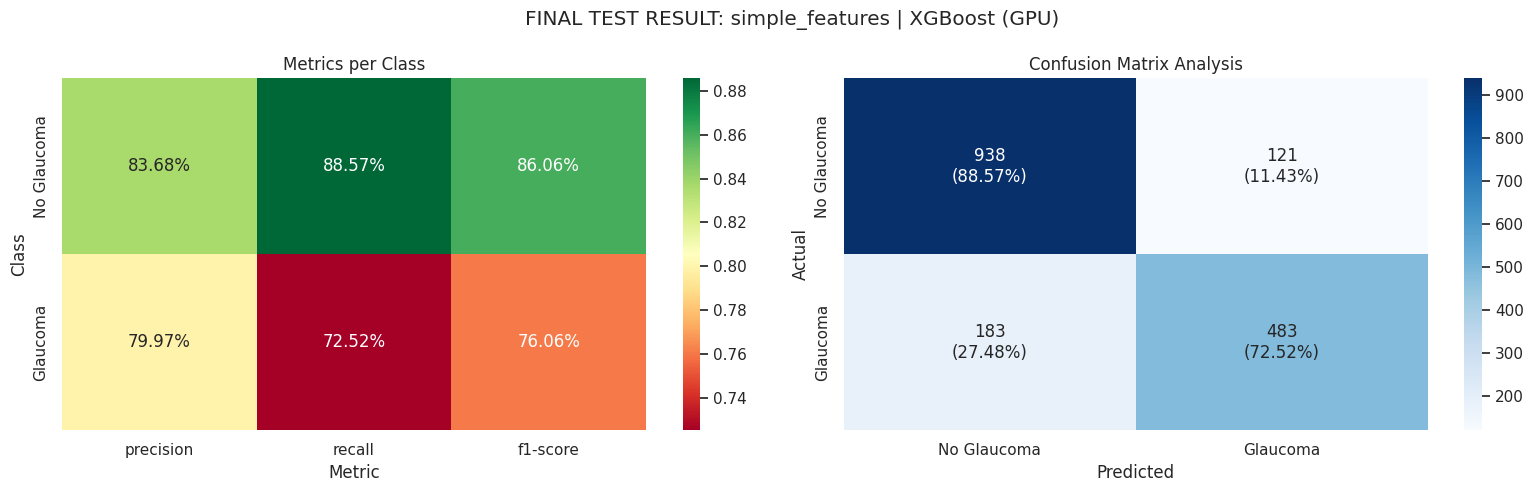

In [66]:
# 1. Retrieve the Winning Details
winning_approach = best_pairs["overall"]["approach"]
winning_model_name = best_pairs["overall"]["model"]

print(f"🔄 Reloading Test Data for winning approach: '{winning_approach}'...")

# 2. Reload the Data Split for the Winner
# We use the same seed (42) so the split is identical to training time
_, _, X_test_final, _, _, y_test_final = data_split(
    df, x_column=winning_approach, y_column="has_glaucoma", n_components=100
)

# 3. Retrieve the Trained Model Object
# We search our 'results' dictionary for the model object matching the name
winning_model = None
for name, model, _, _ in results[winning_approach]:
    if name == winning_model_name:
        winning_model = model
        break

if winning_model:
    print(f"✅ Loaded Model: {winning_model_name}")
    
    # 4. Final Prediction
    print("🚀 Running Final Test Set Prediction...")
    y_pred_final = winning_model.predict(X_test_final)

    # 5. Final Report
    _ = evaluate_predictions(
        y_test_final,
        y_pred_final,
        title=f"FINAL TEST RESULT: {winning_approach} | {winning_model_name}",
    )
else:
    print("❌ Error: Could not find the winning model object in memory.")

In [67]:
# Save the model to disk
save_path = OUTPUT_PATH / "best_glaucoma_model.pkl"

with open(save_path, "wb") as f:
    pickle.dump(winning_model, f)

print(f"💾 Best model saved to: {save_path}")
print("To load: with open('path', 'rb') as f: model = pickle.load(f)")

💾 Best model saved to: /kaggle/working/best_glaucoma_model.pkl
To load: with open('path', 'rb') as f: model = pickle.load(f)


## 11. Conclusion

In this project, we explored the complete pipeline of Classical Machine Learning for Medical Imaging.

**Key Takeaways:**
1.  **Feature Engineering is King:** We observed that moving from "Raw Pixels" (Baseline) to "Hand-Crafted Features" (HOG/LBP) significantly improved performance.
2.  **Domain Knowledge Matters:** Our **ROI Detection** (Experiment 3) and **Physiological Features** (Experiment 4) allowed the models to focus on the Optic Disc, filtering out noise.
3.  **Model Selection:** We compared linear models (Logistic Regression/SVM) vs. non-linear ensembles (Random Forest/XGBoost).

**Next Steps:**
* **Deep Learning:** A Convolutional Neural Network (CNN) would likely outperform these classical methods by learning the features automatically, though it would require more data or Transfer Learning.
* **Explainability:** Using SHAP values to see *which* specific feature (e.g., "Red Channel Std Dev" or "HOG Gradient") contributed most to the diagnosis.